In [92]:
# File processing
import glob
import os

# Data processing
import numpy as np
from tqdm import tqdm

# Data Display
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.legend_handler import HandlerLine2D

# Curve fitting
import pylab as plb
from scipy.optimize import curve_fit

# Machine Learning
import random
import torch
import torch.nn.functional as F
from torch import linalg as LAtorch
from numpy import linalg as LAnumpy
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.data import DataLoader
from sklearn.metrics import mean_squared_error
from torch_geometric.data import Data, InMemoryDataset

# Constants

In [93]:
NB_EPOCHS = 50
BATCH_SIZE = 10
NB_BINS = 202
EMBEDDING_SIZE = 3 # Euclidean 3D space
LEARNING_RATE = 0.001
SEED = 0
TRAIN_DATASET_SIZE = 800
TEST_DATASET_SIZE = 200

# Losses
LAMBDA_MU = 10e-5
LAMBDA_SIGMA = 10e-2
LAMBDA_AMPLITUDE = 10e4

# Structure variation parameters
NB_NORMALS_X = 4
NB_NORMALS_Y = 6
NB_NORMALS_Z = 1

# Trussart analysis dataset constants
TRUSSART_HIC_PATH_50 = '../../../../experiments/data/trussart/hic_matrices/150_TADlike_alpha_50_set0.mat'
TRUSSART_HIC_PATH_100 = '../../../../experiments/data/trussart/hic_matrices/150_TADlike_alpha_100_set0.mat'
TRUSSART_HIC_PATH_150 = '../../../../experiments/data/trussart/hic_matrices/150_TADlike_alpha_150_set0.mat'
TRUSSART_HIC_PATH_200 = '../../../../experiments/data/trussart/hic_matrices/150_TADlike_alpha_200_set0.mat'

TRUSSART_STRUCTURES_PATH = '../../../../experiments/data/trussart/structure_matrices/'

# Seeds

In [94]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Structure analysis functions

### Torch

In [95]:
def centralize_torch(z):
    return z - torch.repeat_interleave(torch.reshape(torch.mean(z, axis=1), (-1,1,EMBEDDING_SIZE)), NB_BINS, dim=1)

In [96]:
def normalize_torch(z):
    
    norms = LAtorch.norm(z, 2, dim=2)
    max_norms, _ = torch.max(norms, axis=1)
    max_norms = torch.reshape(max_norms, (BATCH_SIZE,1,1))
    max_norms = torch.repeat_interleave(max_norms, NB_BINS, dim=1)
    max_norms = torch.repeat_interleave(max_norms, EMBEDDING_SIZE, dim=2)
    max_norms[max_norms == 0] = 1
    
    return z / max_norms

In [97]:
def centralize_and_normalize_torch(z):
    
    # Translate
    z = centralize_torch(z)
    
    # Scale
    z = normalize_torch(z)
    
    return z

### Numpy

In [98]:
def centralize_numpy(z):
    return z - np.mean(z, axis=0)

In [99]:
def normalize_numpy(z):
    
    norm = LAnumpy.norm(z, 2, axis=1)
    max_norm = np.max(norm, axis=0)
    if max_norm == 0:
        max_norm = 1
    
    return z / max_norm

In [100]:
def centralize_and_normalize_numpy(z):
    
    # Translate
    z = centralize_numpy(z)
    
    # Scale
    z = normalize_numpy(z)
    
    return z

In [101]:
def kabsch_superimposition_numpy(pred_structure, true_structure):
    
    # Centralize and normalize to unit ball
    pred_structure_unit_ball = centralize_and_normalize_numpy(pred_structure)
    true_structure_unit_ball = centralize_and_normalize_numpy(true_structure)
    
    # Rotation (solution for the constrained orthogonal Procrustes problem, subject to det(R) = 1)
    m = np.matmul(np.transpose(true_structure_unit_ball), pred_structure_unit_ball)
    u, s, vh = np.linalg.svd(m)
    
    d = np.sign(np.linalg.det(np.matmul(u, vh)))
    a = np.eye(EMBEDDING_SIZE)
    a[-1,-1] = d
    
    r = np.matmul(np.matmul(u, a), vh)
    
    pred_structure_unit_ball = np.transpose(np.matmul(r, np.transpose(pred_structure_unit_ball)))
    
    return pred_structure_unit_ball, true_structure_unit_ball

In [102]:
def kabsch_distance_numpy(pred_structure, true_structure):
    
    pred_structure_unit_ball, true_structure_unit_ball = kabsch_superimposition_numpy(pred_structure, true_structure)
    
    # Structure comparison
    d = np.mean(np.sum(np.square(pred_structure_unit_ball - true_structure_unit_ball), axis=1))
    
    return d

# Create dataset

In [103]:
# grab last 4 digits of the file txt name:
def last_4digits(x):
    return(x[-8:-4])

### Hic matrices

In [104]:
train_transfer_learning_hics = []

file_list = os.listdir('../../data/ensemble/train/hic_matrices/')

for file_name in sorted(filter(lambda x: x.endswith('.txt'), file_list), key = last_4digits):
    current_train_transfer_learning_hic = np.loadtxt('../../data/ensemble/train/hic_matrices/'\
                                                     + file_name, dtype='f', delimiter=' ')
    train_transfer_learning_hics.append(current_train_transfer_learning_hic)

In [105]:
test_transfer_learning_hics = []

file_list = os.listdir('../../data/ensemble/test/hic_matrices/')

for file_name in sorted(filter(lambda x: x.endswith('.txt'), file_list), key = last_4digits):
    current_test_transfer_learning_hic = np.loadtxt('../../data/ensemble/test/hic_matrices/'\
                                                     + file_name, dtype='f', delimiter=' ')
    test_transfer_learning_hics.append(current_test_transfer_learning_hic)

### Mu matrices

In [106]:
train_transfer_learning_mus = []

file_list = os.listdir('../../data/ensemble/train/mu_matrices/')

for file_name in sorted(filter(lambda x: x.endswith('.txt'), file_list), key = last_4digits):
    train_transfer_learning_mu = \
        np.loadtxt('../../data/ensemble/train/mu_matrices/'\
                                                     + file_name, dtype='f', delimiter=' ')
    train_transfer_learning_mus.append(train_transfer_learning_mu)

In [107]:
test_transfer_learning_mus = []

file_list = os.listdir('../../data/ensemble/test/mu_matrices/')

for file_name in sorted(filter(lambda x: x.endswith('.txt'), file_list), key = last_4digits):
    test_transfer_learning_mu = \
        np.loadtxt('../../data/ensemble/test/mu_matrices/'\
                                                     + file_name, dtype='f', delimiter=' ')
    test_transfer_learning_mus.append(test_transfer_learning_mu)

### Sigma matrices

In [108]:
train_transfer_learning_sigmas = []

file_list = os.listdir('../../data/ensemble/train/sigma_matrices/')

for file_name in sorted(filter(lambda x: x.endswith('.txt'), file_list), key = last_4digits):
    train_transfer_learning_sigma = \
        np.loadtxt('../../data/ensemble/train/sigma_matrices/'\
                                                     + file_name, dtype='f', delimiter=' ')
    train_transfer_learning_sigmas.append(train_transfer_learning_sigma)

In [109]:
test_transfer_learning_sigmas = []

file_list = os.listdir('../../data/ensemble/test/sigma_matrices/')

for file_name in sorted(filter(lambda x: x.endswith('.txt'), file_list), key = last_4digits):
    test_transfer_learning_sigma = \
        np.loadtxt('../../data/ensemble/test/sigma_matrices/'\
                                                     + file_name, dtype='f', delimiter=' ')
    test_transfer_learning_sigmas.append(test_transfer_learning_sigma)

### Amplitude matrices

In [110]:
train_transfer_learning_amplitudes = []

file_list = os.listdir('../../data/ensemble/train/amplitude_matrices/')

for file_name in sorted(filter(lambda x: x.endswith('.txt'), file_list), key = last_4digits):
    train_transfer_learning_amplitude = \
        np.loadtxt('../../data/ensemble/train/amplitude_matrices/'\
                                                     + file_name, dtype='f', delimiter=' ')
    train_transfer_learning_amplitudes.append(train_transfer_learning_amplitude)

In [111]:
test_transfer_learning_amplitudes = []

file_list = os.listdir('../../data/ensemble/test/amplitude_matrices/')

for file_name in sorted(filter(lambda x: x.endswith('.txt'), file_list), key = last_4digits):
    test_transfer_learning_amplitude = \
        np.loadtxt('../../data/ensemble/test/amplitude_matrices/'\
                                                     + file_name, dtype='f', delimiter=' ')
    test_transfer_learning_amplitudes.append(test_transfer_learning_amplitude)

# Dispplay tool functions

In [112]:
def normal(x, mu, sigma, amplitude):
    return np.asarray(amplitude * np.exp( - (x - mu)**2 / (2 * sigma**2)))

# Display sample

In [232]:
TEST_SAMPLE = 19

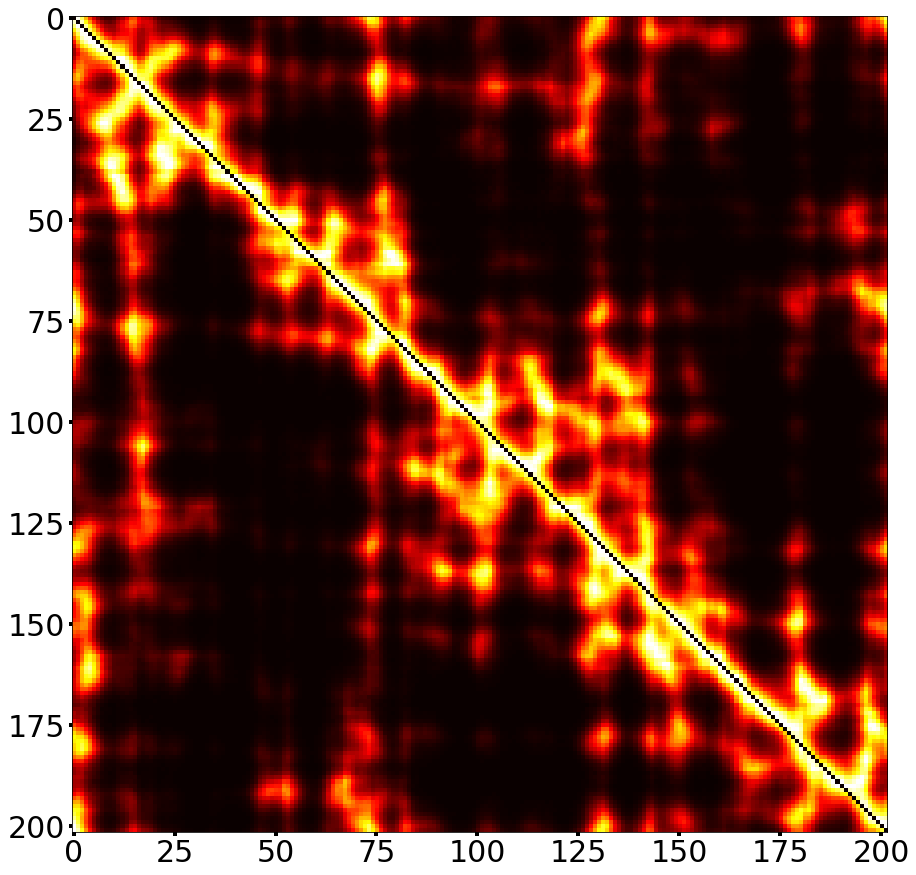

In [250]:
fig, axs = plt.subplots(1, 1, figsize=(15,15))

axs.imshow(trussart_hic_150, cmap='hot', interpolation='nearest')
axs.tick_params(axis='both', which='major', labelsize=30, width=4)

plt.savefig('trussart_ensemble_hic_matrix.png')
plt.show()

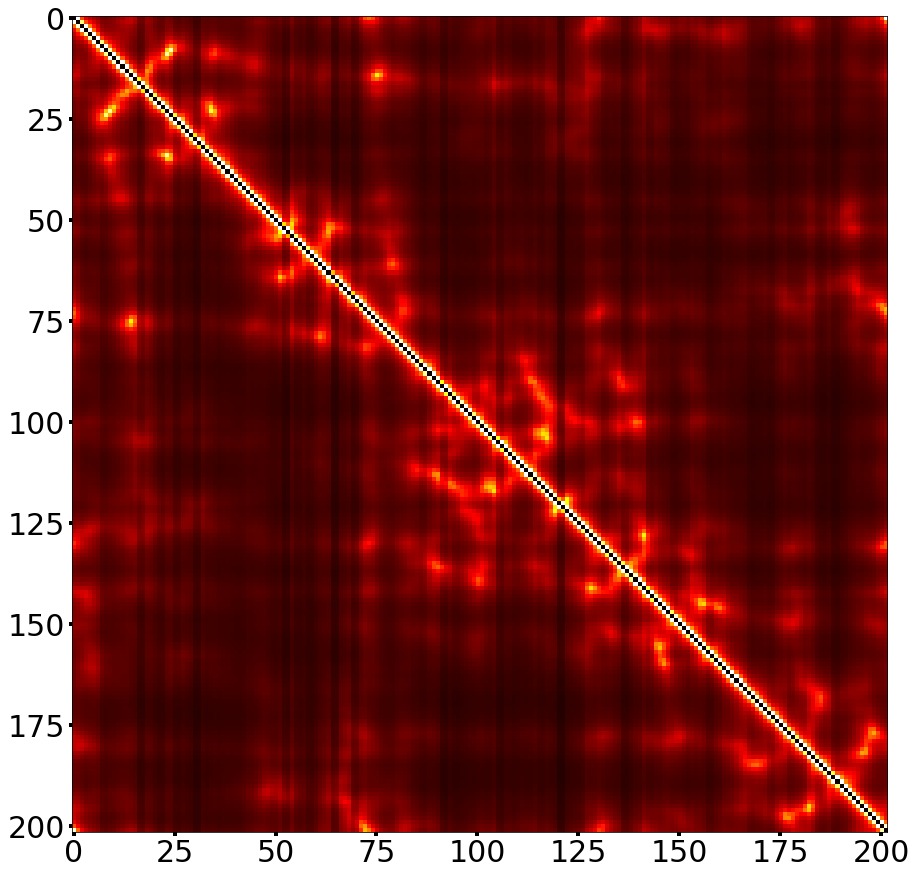

In [233]:
fig, axs = plt.subplots(1, 1, figsize=(15,15))

axs.imshow(train_transfer_learning_hics[TEST_SAMPLE], cmap='hot', interpolation='nearest')
axs.tick_params(axis='both', which='major', labelsize=30, width=4)

plt.savefig('sample_ensemble_hic_matrix.png')
plt.show()

In [234]:
mu = train_transfer_learning_mus[TEST_SAMPLE]
sigma = train_transfer_learning_sigmas[TEST_SAMPLE]
amplitude = train_transfer_learning_amplitudes[TEST_SAMPLE]

mu_x = mu[:NB_NORMALS_X]
mu_y = mu[NB_NORMALS_X:NB_NORMALS_X + NB_NORMALS_Y]
mu_z = mu[NB_NORMALS_X + NB_NORMALS_Y:]
    
sigma_x = sigma[:NB_NORMALS_X]
sigma_y = sigma[NB_NORMALS_X:NB_NORMALS_X + NB_NORMALS_Y]
sigma_z = sigma[NB_NORMALS_X + NB_NORMALS_Y:]
    
amplitude_x = amplitude[:NB_NORMALS_X]
amplitude_y = amplitude[NB_NORMALS_X:NB_NORMALS_X + NB_NORMALS_Y]
amplitude_z = amplitude[NB_NORMALS_X + NB_NORMALS_Y:]
    
predicted_signal_x = np.zeros(NB_BINS)
for i in range(NB_NORMALS_X):
    predicted_signal_x += normal(np.arange(NB_BINS), mu_x[i], sigma_x[i], amplitude_x[i])
    
predicted_signal_y = np.zeros(NB_BINS)
for i in range(NB_NORMALS_Y):
    predicted_signal_y += normal(np.arange(NB_BINS), mu_y[i], sigma_y[i], amplitude_y[i])

predicted_signal_z = np.zeros(NB_BINS)
for i in range(NB_NORMALS_Z):
    predicted_signal_z += normal(np.arange(NB_BINS), mu_z[i], sigma_z[i], amplitude_z[i])

predicted_signal = np.zeros((NB_BINS, EMBEDDING_SIZE))
predicted_signal[:,0] = predicted_signal_x
predicted_signal[:,1] = predicted_signal_y
predicted_signal[:,2] = predicted_signal_z

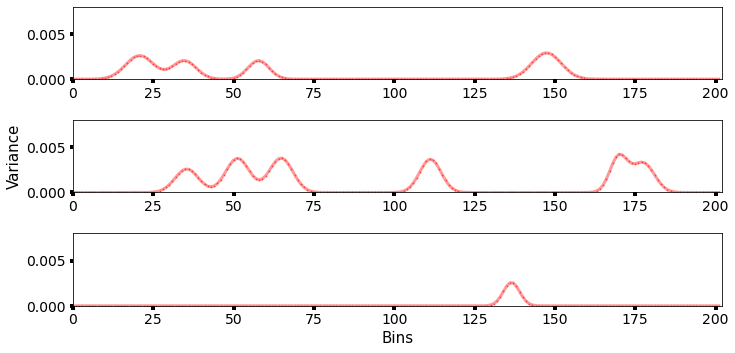

In [249]:
fig, axs = plt.subplots(3, 1, figsize=(10, 5))
fig.tight_layout(pad=2.0)
axis_names = ['X','Y','Z']

# Plot prediction
for i in range(EMBEDDING_SIZE):
    
    axs[i].plot(range(NB_BINS), predicted_signal[:, i], color='red', 
              marker='o', linestyle='solid', linewidth=3, markersize=1, alpha=0.4)
    
#     axs[i].set_title('Structure variance on axis ' + axis_names[i], fontsize=20)
    axs[i].set_xlim(0, NB_BINS)
    axs[i].set_ylim(0, 0.008)
    axs[i].tick_params(axis='both', which='major', labelsize=14, width=4)
    
    if i == 2:
        axs[i].set_xlabel('Bins', fontsize=15)
    if i == 1:
        axs[i].set_ylabel('Variance', fontsize=15)

plt.savefig('sample_per_axis_structure_variance.png')

plt.show()

### Final dataset

#### Training

In [117]:
is_training = True

In [118]:
class VanillaDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(VanillaDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        if is_training:
            return ['ensemble_train_data.txt']
        else:
            return ['ensemble_test_data.txt']

    def download(self):
        pass
        
    def process(self):
        
        data_list = []
        if is_training:
            dataset_size = TRAIN_DATASET_SIZE
        else:
            dataset_size = TEST_DATASET_SIZE
        
        for i in tqdm(range(dataset_size)):
            
            if is_training:
                transfer_learning_hic = train_transfer_learning_hics[i]
                transfer_learning_mu = train_transfer_learning_mus[i]
                transfer_learning_sigma = train_transfer_learning_sigmas[i]
                transfer_learning_amplitude = train_transfer_learning_amplitudes[i]
            else:
                transfer_learning_hic = test_transfer_learning_hics[i]
                transfer_learning_mu = test_transfer_learning_mus[i]
                transfer_learning_sigma = test_transfer_learning_sigmas[i]
                transfer_learning_amplitude = test_transfer_learning_amplitudes[i]
            
            # Add gradients to HiC 
            hic_matrix = np.zeros((3, NB_BINS, NB_BINS))
            hic_matrix[0] = transfer_learning_hic
            hic_matrix[1] = np.gradient(transfer_learning_hic)[0]
            hic_matrix[2] = np.gradient(transfer_learning_hic)[1]
            
            hic_matrix = torch.FloatTensor(hic_matrix)
            mu_matrix = torch.FloatTensor(transfer_learning_mu)
            sigma_matrix = torch.FloatTensor(transfer_learning_sigma)
            amplitude_matrix = torch.FloatTensor(transfer_learning_amplitude)
            
            data = Data(hic_matrix=hic_matrix, 
                        mu_matrix=mu_matrix, 
                        sigma_matrix=sigma_matrix, 
                        amplitude_matrix=amplitude_matrix)
            
            data_list.append(data)
            
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [119]:
train_dataset = VanillaDataset('../')
train_dataset = train_dataset.shuffle()

In [120]:
train_size = len(train_dataset)
train_size

800

800

In [121]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

#### Testing

In [122]:
is_training = False

In [123]:
test_dataset = VanillaDataset('../')
test_dataset = test_dataset.shuffle()

In [124]:
test_size = len(test_dataset)
test_size

200

200

In [125]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Convolutional Neural Network

In [126]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_encoder_layer_1 = torch.nn.Conv2d(in_channels=3, out_channels=4, kernel_size=64, stride=10)
        self.pool_encoder_layer_1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

#         self.conv_encoder_layer_1 = torch.nn.Conv2d(in_channels=3, out_channels=4, kernel_size=8, stride=4)
#         self.pool_encoder_layer_1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
#         self.conv_encoder_layer_2 = torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=8, stride=4)
#         self.pool_encoder_layer_2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.linear_encoder_layer_mu = torch.nn.Linear(196, NB_NORMALS_X + NB_NORMALS_Y + NB_NORMALS_Z)
#         self.linear_encoder_layer_mus_y = torch.nn.Linear(196, NB_NORMALS_Y)
#         self.linear_encoder_layer_mus_z = torch.nn.Linear(196, NB_NORMALS_Z)
        
        self.linear_encoder_layer_sigma = torch.nn.Linear(196, NB_NORMALS_X + NB_NORMALS_Y + NB_NORMALS_Z)
#         self.linear_encoder_layer_sigmas_y = torch.nn.Linear(196, NB_NORMALS_Y)
#         self.linear_encoder_layer_sigmas_z = torch.nn.Linear(196, NB_NORMALS_Z)
        
        self.linear_encoder_layer_amplitude = torch.nn.Linear(196, NB_NORMALS_X + NB_NORMALS_Y + NB_NORMALS_Z)
#         self.linear_encoder_layer_amplitudes_y = torch.nn.Linear(196, NB_NORMALS_Y)
#         self.linear_encoder_layer_amplitudes_z = torch.nn.Linear(196, NB_NORMALS_Z)
        
    def forward(self, x):
        
        x = torch.reshape(x, (BATCH_SIZE, 3, NB_BINS, NB_BINS))
        
#         print(x.size())
        
        t = self.conv_encoder_layer_1(x)
        
#         print(t.size())
        
        t = self.pool_encoder_layer_1(t)
        
#         print(t.size())
        
#         t = self.conv_encoder_layer_2(t)
        
#         print(t.size())
        
#         t = self.pool_encoder_layer_2(t)
        
#         print(t.size())
        
        t = torch.reshape(t, (BATCH_SIZE, -1))
        
#         print(t.size())
        
        
        mu = self.linear_encoder_layer_mu(t)
        mu = F.relu(mu)
        mu = torch.clamp(mu, min=0, max=NB_BINS)
        
#         mus_y = self.linear_encoder_layer_mus_y(t)
#         mus_y = F.relu(mus_y)
#         mus_y = torch.clamp(mus_y, min=0, max=NB_BINS)

#         mus_z = self.linear_encoder_layer_mus_z(t)
#         mus_z = F.relu(mus_z)
#         mus_z = torch.clamp(mus_z, min=0, max=NB_BINS)
        
        
        sigma = self.linear_encoder_layer_sigma(t)
        sigma = F.relu(sigma)
        sigma = torch.clamp(sigma, min=2, max=5)
        
#         sigmas_y = self.linear_encoder_layer_sigmas_y(t)
#         sigmas_y = F.relu(sigmas_y)
#         sigmas_y = torch.clamp(sigmas_y, min=2, max=5)
        
#         sigmas_z = self.linear_encoder_layer_sigmas_z(t)
#         sigmas_z = F.relu(sigmas_z)
#         sigmas_z = torch.clamp(sigmas_z, min=2, max=5)
        
        
        amplitude = self.linear_encoder_layer_amplitude(t)
        amplitude = F.relu(amplitude)
        amplitude = torch.clamp(amplitude, min=0.002, max=0.004)
        
#         amplitude_y = self.linear_encoder_layer_amplitudes_y(t)
#         amplitude_y = F.relu(amplitude_y)
#         amplitude_y = torch.clamp(amplitude_y, min=0.002, max=0.004)
        
#         amplitude_z = self.linear_encoder_layer_amplitudes_z(t)
#         amplitude_z = F.relu(amplitude_z)
#         amplitude_z = torch.clamp(amplitude_z, min=0.002, max=0.004)
        
#         mu = torch.hstack((torch.hstack((mus_x, mus_y)), mus_z))
#         sigma = torch.hstack((torch.hstack((sigmas_x, sigmas_y)), sigmas_z))
#         amplitude = torch.hstack((torch.hstack((amplitude_x, amplitude_y)), amplitude_z))

        return mu, sigma, amplitude

# Losses

In [127]:
loss_mu = torch.nn.MSELoss()
loss_sigma = torch.nn.MSELoss()
loss_amplitude = torch.nn.MSELoss()

# Train and test

In [128]:
device = torch.device('cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [129]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([matplotlib.lines.Line2D([0], [0], color="c", lw=4),
                matplotlib.lines.Line2D([0], [0], color="b", lw=4),
                matplotlib.lines.Line2D([0], [0], color="k", lw=4)], 
               ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [130]:
def train():
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        pred_mu, pred_sigma, pred_amplitude = model(data.hic_matrix)
        
        true_mu = data.mu_matrix.to(device)
        true_mu = torch.reshape(true_mu, (BATCH_SIZE, NB_NORMALS_X + NB_NORMALS_Y + NB_NORMALS_Z))
        
        true_sigma = data.sigma_matrix.to(device)
        true_sigma = torch.reshape(true_sigma, (BATCH_SIZE, NB_NORMALS_X + NB_NORMALS_Y + NB_NORMALS_Z))
        
        true_amplitude = data.amplitude_matrix.to(device)
        true_amplitude = torch.reshape(true_amplitude, (BATCH_SIZE, NB_NORMALS_X + NB_NORMALS_Y + NB_NORMALS_Z))
        
        # Loss
        loss =  LAMBDA_MU * loss_mu(pred_mu, true_mu) + \
                LAMBDA_SIGMA * loss_sigma(pred_sigma, true_sigma) + \
                LAMBDA_AMPLITUDE * loss_amplitude(pred_amplitude, true_amplitude)
        
#         with torch.autograd.detect_anomaly():
        loss.backward()
        
        loss_all += data.num_graphs * loss.item()
        
        # Plot grad flow
#         plot_grad_flow(model.named_parameters())
        
        optimizer.step()
    return loss_all / len(train_dataset)

In [131]:
def evaluate(loader):
    model.eval()
    
    pred_mus = []
    true_mus = []
    
    pred_sigmas = []
    true_sigmas = []
    
    pred_amplitudes = []
    true_amplitudes = []
    
    mu_losses = []
    sigma_losses = []
    amplitude_losses = []

    with torch.no_grad():
        for data in loader:

            data = data.to(device)
            
            pred_mu, pred_sigma, pred_amplitude = model(data.hic_matrix)
            
            pred_mu = pred_mu.detach().cpu()
            pred_sigma = pred_sigma.detach().cpu()
            pred_amplitude = pred_amplitude.detach().cpu()
            
            true_mu = data.mu_matrix.detach().cpu()
            true_sigma = data.sigma_matrix.detach().cpu()
            true_amplitude = data.amplitude_matrix.detach().cpu()
            
            true_mu = torch.reshape(true_mu, (BATCH_SIZE, NB_NORMALS_X + NB_NORMALS_Y + NB_NORMALS_Z))
            true_sigma = torch.reshape(true_sigma, (BATCH_SIZE, NB_NORMALS_X + NB_NORMALS_Y + NB_NORMALS_Z))
            true_amplitude = \
                torch.reshape(true_amplitude, (BATCH_SIZE, NB_NORMALS_X + NB_NORMALS_Y + NB_NORMALS_Z))

            # Mu loss
            mu_losses.append(loss_mu(pred_mu, true_mu))
            
            # Sigma Loss
            sigma_losses.append(loss_sigma(pred_sigma, true_sigma))
            
            # Amplitude Loss
            amplitude_losses.append(loss_amplitude(pred_amplitude, true_amplitude))
            
            # To numpy
            pred_mu = pred_mu.numpy()
            true_mu = true_mu.numpy()
            
            pred_sigma = pred_sigma.numpy()
            true_sigma = true_sigma.numpy()
            
            pred_amplitude = pred_amplitude.numpy()
            true_amplitude = true_amplitude.numpy()
            
            # Store results
            pred_mus.append(pred_mu)
            true_mus.append(true_mu)
            
            pred_sigmas.append(pred_sigma)
            true_sigmas.append(true_sigma)
            
            pred_amplitudes.append(pred_amplitude)
            true_amplitudes.append(true_amplitude)
            
    # Format results
    pred_mus = np.vstack(pred_mus)
    true_mus = np.vstack(true_mus)
    
    pred_sigmas = np.vstack(pred_sigmas)
    true_sigmas = np.vstack(true_sigmas)
    
    pred_amplitudes = np.vstack(pred_amplitudes)
    true_amplitudes = np.vstack(true_amplitudes)
    
    # Compute mean losses
    mean_mu_loss = np.mean(np.asarray(mu_losses).flatten())
    mean_sigma_loss = np.mean(np.asarray(sigma_losses).flatten())
    mean_amplitude_loss = np.mean(np.asarray(amplitude_losses).flatten())
    
    return mean_mu_loss, mean_sigma_loss, mean_amplitude_loss, \
        pred_mus, true_mus, pred_sigmas, true_sigmas, pred_amplitudes, true_amplitudes

In [132]:
train_mu_losses_all_epochs = []
test_mu_losses_all_epochs = []

train_sigma_losses_all_epochs = []
test_sigma_losses_all_epochs = []

train_amplitude_losses_all_epochs = []
test_amplitude_losses_all_epochs = []

losses = []

for epoch in range(1, NB_EPOCHS+1):
    loss = train()
    losses.append(loss)
    
    ### Training
    train_mean_mu_loss, train_mean_sigma_loss, train_mean_amplitude_loss, \
        train_pred_mus, train_true_mus, train_pred_sigmas, train_true_sigmas, train_pred_amplitudes, \
            train_true_amplitudes = evaluate(train_loader) 
    
    # Store results
    train_mu_losses_all_epochs.append(train_mean_mu_loss)
    train_sigma_losses_all_epochs.append(train_mean_sigma_loss)
    train_amplitude_losses_all_epochs.append(train_mean_amplitude_loss)
    
    ### Testing
    test_mean_mu_loss, test_mean_sigma_loss, test_mean_amplitude_loss, \
        test_pred_mus, test_true_mus, test_pred_sigmas, test_true_sigmas, test_pred_amplitudes, \
            test_true_amplitudes = evaluate(test_loader)
    
    # Store results
    test_mu_losses_all_epochs.append(test_mean_mu_loss)
    test_sigma_losses_all_epochs.append(test_mean_sigma_loss)
    test_amplitude_losses_all_epochs.append(test_mean_amplitude_loss)
    
    print('E: {:03d}, Tr m: {:.4f}, Tr s: {:.4f}, Tr a: {:.4f}, Te m: {:.4f}, Te s: {:.4f}, Te a: {:.4f}'.format(epoch, LAMBDA_MU*train_mean_mu_loss, LAMBDA_SIGMA*train_mean_sigma_loss, LAMBDA_AMPLITUDE*train_mean_amplitude_loss, LAMBDA_MU*test_mean_mu_loss, LAMBDA_SIGMA*test_mean_sigma_loss, LAMBDA_AMPLITUDE*test_mean_amplitude_loss))

E: 001, Tr m: 0.7944, Tr s: 0.2175, Tr a: 0.1343, Te m: 0.8114, Te s: 0.2177, Te a: 0.1334
E: 001, Tr m: 0.7944, Tr s: 0.2175, Tr a: 0.1343, Te m: 0.8114, Te s: 0.2177, Te a: 0.1334
E: 002, Tr m: 0.7933, Tr s: 0.2042, Tr a: 0.1343, Te m: 0.8099, Te s: 0.2048, Te a: 0.1334
E: 002, Tr m: 0.7933, Tr s: 0.2042, Tr a: 0.1343, Te m: 0.8099, Te s: 0.2048, Te a: 0.1334
E: 003, Tr m: 0.7933, Tr s: 0.2018, Tr a: 0.1343, Te m: 0.8099, Te s: 0.2023, Te a: 0.1334
E: 003, Tr m: 0.7933, Tr s: 0.2018, Tr a: 0.1343, Te m: 0.8099, Te s: 0.2023, Te a: 0.1334
E: 004, Tr m: 0.7934, Tr s: 0.2005, Tr a: 0.1343, Te m: 0.8099, Te s: 0.2010, Te a: 0.1334
E: 004, Tr m: 0.7934, Tr s: 0.2005, Tr a: 0.1343, Te m: 0.8099, Te s: 0.2010, Te a: 0.1334
E: 005, Tr m: 0.7934, Tr s: 0.1998, Tr a: 0.1343, Te m: 0.8099, Te s: 0.2003, Te a: 0.1334
E: 005, Tr m: 0.7934, Tr s: 0.1998, Tr a: 0.1343, Te m: 0.8099, Te s: 0.2003, Te a: 0.1334
E: 006, Tr m: 0.7934, Tr s: 0.1994, Tr a: 0.1343, Te m: 0.8099, Te s: 0.1999, Te a: 0.1334

E: 046, Tr m: 0.7939, Tr s: 0.2026, Tr a: 0.1343, Te m: 0.8105, Te s: 0.2030, Te a: 0.1334
E: 047, Tr m: 0.7939, Tr s: 0.2026, Tr a: 0.1343, Te m: 0.8105, Te s: 0.2029, Te a: 0.1334
E: 047, Tr m: 0.7939, Tr s: 0.2026, Tr a: 0.1343, Te m: 0.8105, Te s: 0.2029, Te a: 0.1334
E: 048, Tr m: 0.7939, Tr s: 0.2025, Tr a: 0.1343, Te m: 0.8105, Te s: 0.2029, Te a: 0.1334
E: 048, Tr m: 0.7939, Tr s: 0.2025, Tr a: 0.1343, Te m: 0.8105, Te s: 0.2029, Te a: 0.1334
E: 049, Tr m: 0.7939, Tr s: 0.2025, Tr a: 0.1343, Te m: 0.8105, Te s: 0.2028, Te a: 0.1334
E: 049, Tr m: 0.7939, Tr s: 0.2025, Tr a: 0.1343, Te m: 0.8105, Te s: 0.2028, Te a: 0.1334
E: 050, Tr m: 0.7939, Tr s: 0.2024, Tr a: 0.1343, Te m: 0.8105, Te s: 0.2028, Te a: 0.1334
E: 050, Tr m: 0.7939, Tr s: 0.2024, Tr a: 0.1343, Te m: 0.8105, Te s: 0.2028, Te a: 0.1334


In [133]:
# E: 050, Tr m: 0.7289, Tr s: 0.3407, Tr a: 0.1329, Te m: 0.7351, Te s: 0.3491, Te a: 0.1354

In [134]:
test_pred_mus

array([[  0.      ,  91.707924, 100.24835 , ..., 101.70084 ,   0.      ,
         94.117966],
       [  0.      ,  91.81403 , 100.373795, ..., 101.81909 ,   0.      ,
         94.21515 ],
       [  0.      ,  91.78943 , 100.32408 , ..., 101.77154 ,   0.      ,
         94.19354 ],
       ...,
       [  0.      ,  92.77195 , 101.26637 , ..., 102.81109 ,   0.      ,
         95.07773 ],
       [  0.      ,  91.71463 , 100.25864 , ..., 101.70658 ,   0.      ,
         94.12895 ],
       [  0.      ,  92.30229 , 100.78654 , ..., 102.29369 ,   0.      ,
         94.64763 ]], dtype=float32)

array([[  0.      ,  91.707924, 100.24835 , ..., 101.70084 ,   0.      ,
         94.117966],
       [  0.      ,  91.81403 , 100.373795, ..., 101.81909 ,   0.      ,
         94.21515 ],
       [  0.      ,  91.78943 , 100.32408 , ..., 101.77154 ,   0.      ,
         94.19354 ],
       ...,
       [  0.      ,  92.77195 , 101.26637 , ..., 102.81109 ,   0.      ,
         95.07773 ],
       [  0.      ,  91.71463 , 100.25864 , ..., 101.70658 ,   0.      ,
         94.12895 ],
       [  0.      ,  92.30229 , 100.78654 , ..., 102.29369 ,   0.      ,
         94.64763 ]], dtype=float32)

In [135]:
 test_true_mus

array([[ 30.043987,  75.385056,  26.949715, ...,  33.24358 ,  99.844185,
         32.545326],
       [ 89.17169 , 116.96253 , 201.94925 , ...,  90.04889 ,  33.983315,
         79.138084],
       [ 96.03934 , 159.39775 , 193.03835 , ..., 179.1809  , 199.50565 ,
         57.30299 ],
       ...,
       [ 96.086555, 156.77446 ,  23.924734, ..., 182.68661 ,  54.696922,
         55.349407],
       [196.9512  ,  57.383217,  89.50944 , ...,  79.69201 , 168.19336 ,
        138.05904 ],
       [141.82635 ,  49.79907 , 135.96532 , ..., 173.63695 , 114.997246,
        197.9872  ]], dtype=float32)

array([[ 30.043987,  75.385056,  26.949715, ...,  33.24358 ,  99.844185,
         32.545326],
       [ 89.17169 , 116.96253 , 201.94925 , ...,  90.04889 ,  33.983315,
         79.138084],
       [ 96.03934 , 159.39775 , 193.03835 , ..., 179.1809  , 199.50565 ,
         57.30299 ],
       ...,
       [ 96.086555, 156.77446 ,  23.924734, ..., 182.68661 ,  54.696922,
         55.349407],
       [196.9512  ,  57.383217,  89.50944 , ...,  79.69201 , 168.19336 ,
        138.05904 ],
       [141.82635 ,  49.79907 , 135.96532 , ..., 173.63695 , 114.997246,
        197.9872  ]], dtype=float32)

In [136]:
test_pred_sigmas

array([[3.0122929, 2.       , 3.5732572, ..., 2.       , 2.       ,
        3.092652 ],
       [3.0072672, 2.       , 3.595226 , ..., 2.       , 2.       ,
        3.0985734],
       [3.0256703, 2.       , 3.6062682, ..., 2.       , 2.       ,
        3.086122 ],
       ...,
       [2.9784818, 2.       , 3.4177804, ..., 2.       , 2.       ,
        3.1204567],
       [3.024742 , 2.       , 3.5961447, ..., 2.       , 2.       ,
        3.0782545],
       [3.0123496, 2.       , 3.4903483, ..., 2.       , 2.       ,
        3.0829666]], dtype=float32)

array([[3.0122929, 2.       , 3.5732572, ..., 2.       , 2.       ,
        3.092652 ],
       [3.0072672, 2.       , 3.595226 , ..., 2.       , 2.       ,
        3.0985734],
       [3.0256703, 2.       , 3.6062682, ..., 2.       , 2.       ,
        3.086122 ],
       ...,
       [2.9784818, 2.       , 3.4177804, ..., 2.       , 2.       ,
        3.1204567],
       [3.024742 , 2.       , 3.5961447, ..., 2.       , 2.       ,
        3.0782545],
       [3.0123496, 2.       , 3.4903483, ..., 2.       , 2.       ,
        3.0829666]], dtype=float32)

In [137]:
test_true_sigmas

array([[4.927388 , 3.3500907, 2.7842522, ..., 4.2747126, 2.7244356,
        3.5953505],
       [2.7632966, 2.2655265, 4.353714 , ..., 2.9648414, 3.4632304,
        3.6238627],
       [3.0525362, 2.4912465, 4.883313 , ..., 3.1536863, 4.709794 ,
        4.0002146],
       ...,
       [4.590094 , 4.268827 , 2.7088306, ..., 2.6902351, 4.161028 ,
        2.1855962],
       [2.0674913, 3.2835374, 4.986298 , ..., 4.8389015, 3.869944 ,
        2.123777 ],
       [2.0398796, 4.690745 , 4.549413 , ..., 4.8104157, 4.915393 ,
        4.928222 ]], dtype=float32)

array([[4.927388 , 3.3500907, 2.7842522, ..., 4.2747126, 2.7244356,
        3.5953505],
       [2.7632966, 2.2655265, 4.353714 , ..., 2.9648414, 3.4632304,
        3.6238627],
       [3.0525362, 2.4912465, 4.883313 , ..., 3.1536863, 4.709794 ,
        4.0002146],
       ...,
       [4.590094 , 4.268827 , 2.7088306, ..., 2.6902351, 4.161028 ,
        2.1855962],
       [2.0674913, 3.2835374, 4.986298 , ..., 4.8389015, 3.869944 ,
        2.123777 ],
       [2.0398796, 4.690745 , 4.549413 , ..., 4.8104157, 4.915393 ,
        4.928222 ]], dtype=float32)

In [138]:
test_pred_amplitudes

array([[0.002, 0.002, 0.002, ..., 0.004, 0.004, 0.002],
       [0.002, 0.002, 0.002, ..., 0.004, 0.004, 0.002],
       [0.002, 0.002, 0.002, ..., 0.004, 0.004, 0.002],
       ...,
       [0.002, 0.002, 0.002, ..., 0.004, 0.004, 0.002],
       [0.002, 0.002, 0.002, ..., 0.004, 0.004, 0.002],
       [0.002, 0.002, 0.002, ..., 0.004, 0.004, 0.002]], dtype=float32)

array([[0.002, 0.002, 0.002, ..., 0.004, 0.004, 0.002],
       [0.002, 0.002, 0.002, ..., 0.004, 0.004, 0.002],
       [0.002, 0.002, 0.002, ..., 0.004, 0.004, 0.002],
       ...,
       [0.002, 0.002, 0.002, ..., 0.004, 0.004, 0.002],
       [0.002, 0.002, 0.002, ..., 0.004, 0.004, 0.002],
       [0.002, 0.002, 0.002, ..., 0.004, 0.004, 0.002]], dtype=float32)

In [139]:
test_true_amplitudes

array([[0.00284368, 0.00355632, 0.00201482, ..., 0.00348756, 0.00388716,
        0.0023563 ],
       [0.0027815 , 0.00225072, 0.00398539, ..., 0.00355894, 0.00366997,
        0.00235561],
       [0.00302575, 0.00230946, 0.00380373, ..., 0.00209607, 0.00304785,
        0.00348389],
       ...,
       [0.00355972, 0.00310152, 0.00215559, ..., 0.00287901, 0.0029992 ,
        0.0028619 ],
       [0.00320705, 0.00302944, 0.00391603, ..., 0.00320301, 0.00244926,
        0.00315757],
       [0.00217806, 0.00390544, 0.00374726, ..., 0.00358629, 0.00254602,
        0.00215755]], dtype=float32)

array([[0.00284368, 0.00355632, 0.00201482, ..., 0.00348756, 0.00388716,
        0.0023563 ],
       [0.0027815 , 0.00225072, 0.00398539, ..., 0.00355894, 0.00366997,
        0.00235561],
       [0.00302575, 0.00230946, 0.00380373, ..., 0.00209607, 0.00304785,
        0.00348389],
       ...,
       [0.00355972, 0.00310152, 0.00215559, ..., 0.00287901, 0.0029992 ,
        0.0028619 ],
       [0.00320705, 0.00302944, 0.00391603, ..., 0.00320301, 0.00244926,
        0.00315757],
       [0.00217806, 0.00390544, 0.00374726, ..., 0.00358629, 0.00254602,
        0.00215755]], dtype=float32)

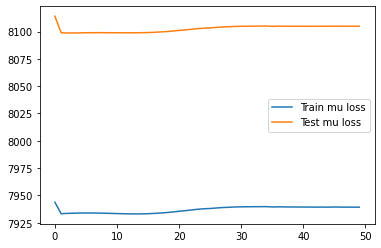

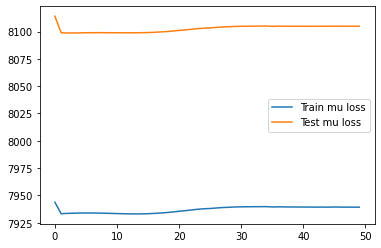

In [140]:
plt.plot(train_mu_losses_all_epochs, label='Train mu loss')
plt.plot(test_mu_losses_all_epochs, label='Test mu loss')

plt.legend()
plt.show()

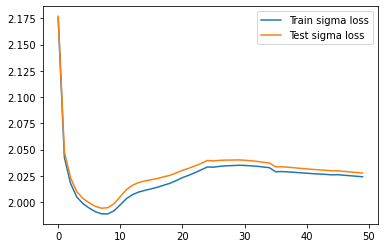

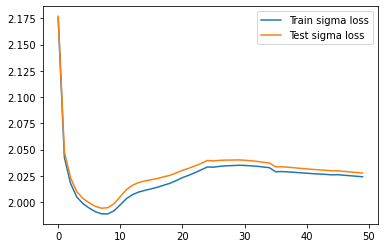

In [141]:
plt.plot(train_sigma_losses_all_epochs, label='Train sigma loss')
plt.plot(test_sigma_losses_all_epochs, label='Test sigma loss')

plt.legend()
plt.show()

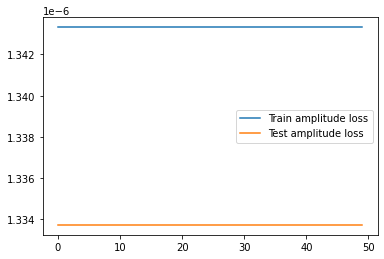

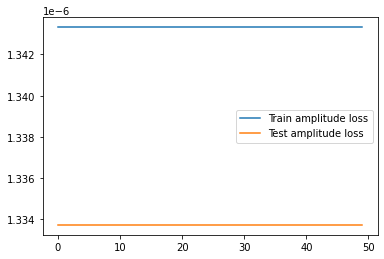

In [142]:
plt.plot(train_amplitude_losses_all_epochs, label='Train amplitude loss')
plt.plot(test_amplitude_losses_all_epochs, label='Test amplitude loss')

plt.legend()
plt.show()

# Statistical testing

### mu

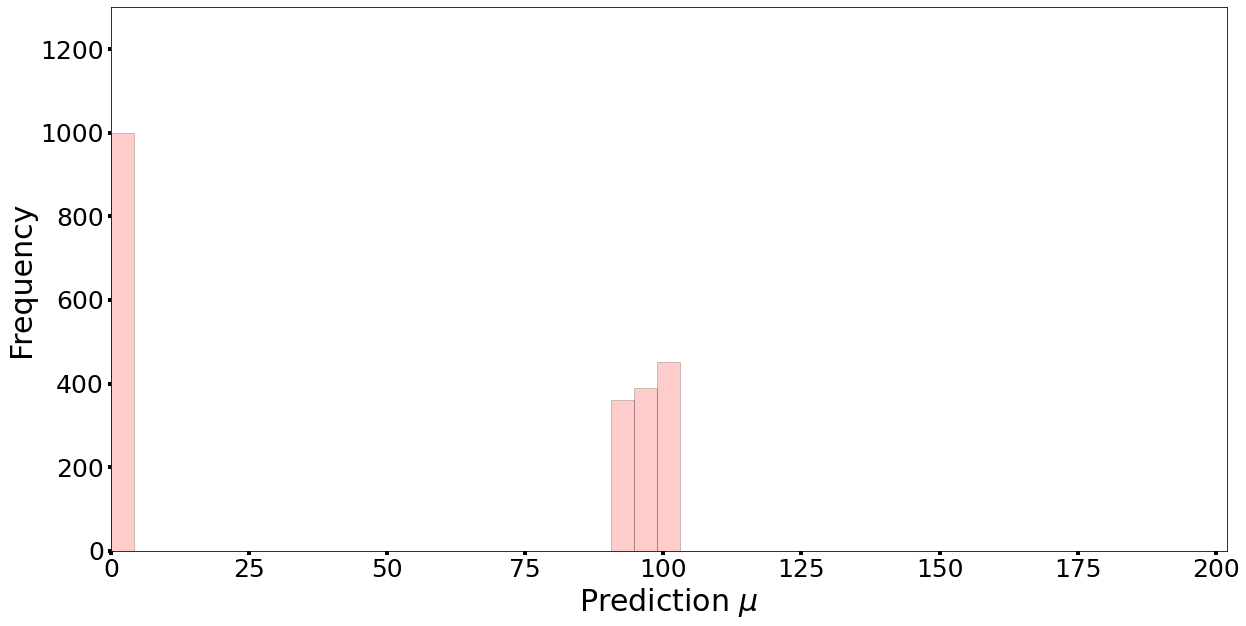

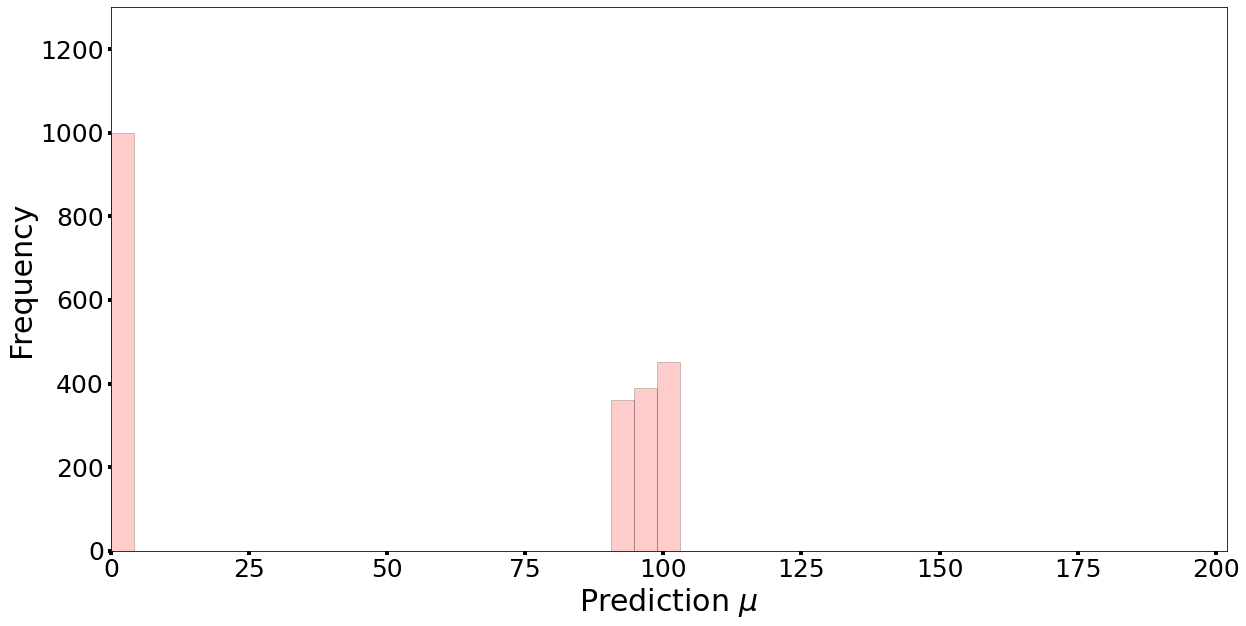

In [200]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))

n, bins, patches = plt.hist(test_pred_mus.flatten(), bins=25, 
         facecolor='red', linewidth=1, edgecolor='black', alpha=0.2)

axs.set_ylabel('Frequency', fontsize = 30)
axs.set_xlabel('Prediction ' + r'$\mu$' , fontsize = 30)
axs.set_ylim(0, 1300)
axs.set_xlim(0, NB_BINS)

axs.tick_params(axis='both', which='major', labelsize=25, width=4)

plt.savefig('mu_prediction_distribution.png')
plt.show()

In [144]:
random_mu_true = np.random.uniform(low=0, high=NB_BINS, 
                        size=TEST_DATASET_SIZE * (NB_NORMALS_X + NB_NORMALS_Y + NB_NORMALS_Z))
# random_mu_pred = np.random.uniform(low=0, high=NB_BINS, 
#                         size=TEST_DATASET_SIZE * (NB_NORMALS_X + NB_NORMALS_Y + NB_NORMALS_Z))
random_mu_pred = np.full(TEST_DATASET_SIZE * (NB_NORMALS_X + NB_NORMALS_Y + NB_NORMALS_Z), NB_BINS / 2.0)

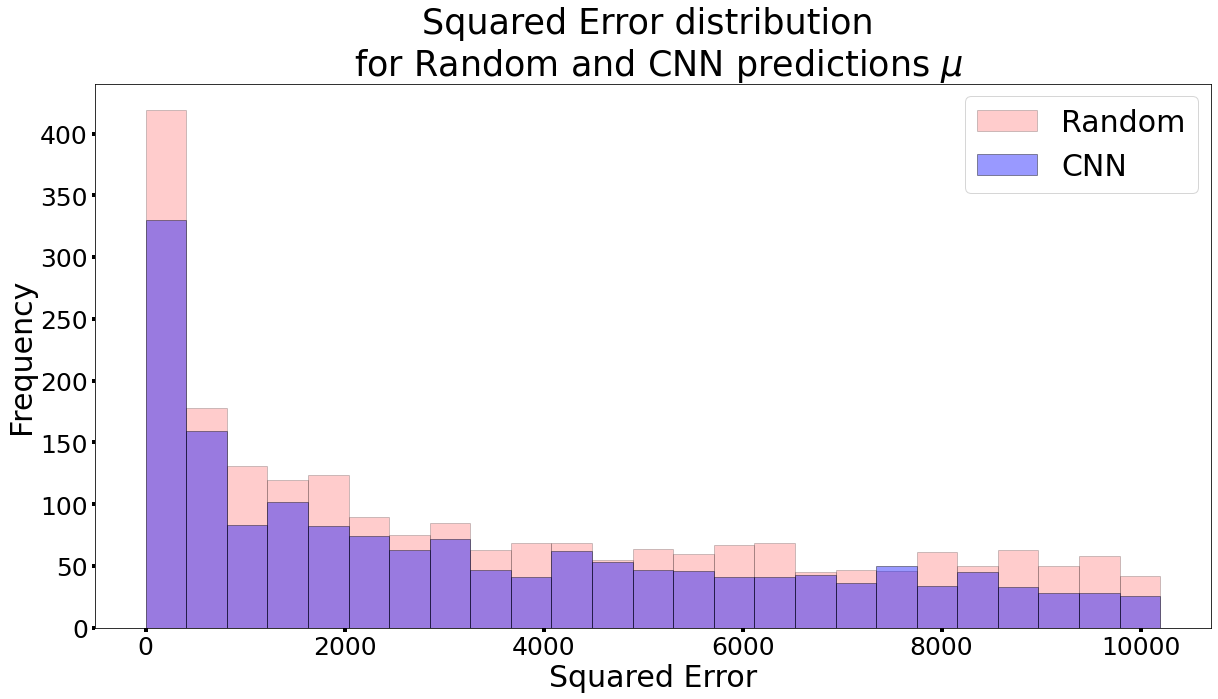

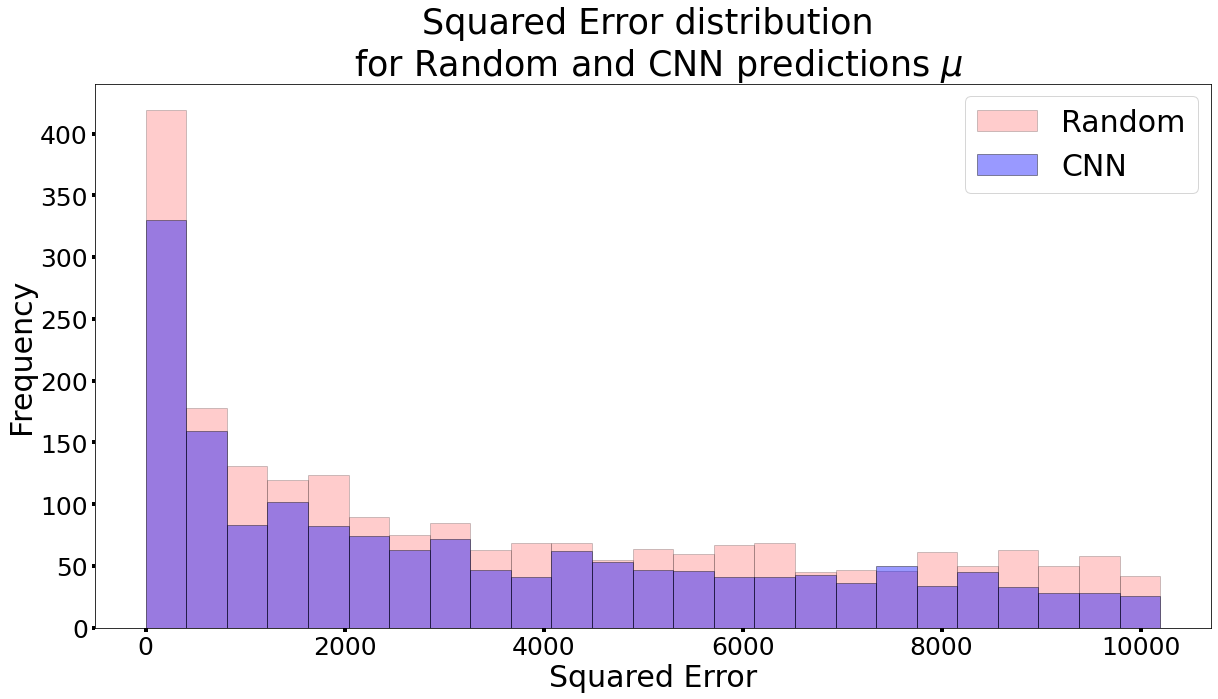

In [145]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))

random_distribution_mu = (random_mu_pred - random_mu_true)**2
test_distribution_mu = (test_pred_mus.flatten() - test_true_mus.flatten())**2

n, bins, patches = plt.hist(random_distribution_mu, bins=25, 
         facecolor='red', linewidth=1, edgecolor='black', alpha=0.2, label='Random')
plt.hist(test_distribution_mu, bins=bins, 
         facecolor='blue', linewidth=1, edgecolor='black', alpha=0.4, label='CNN')

axs.set_ylabel('Frequency', fontsize = 30)
axs.set_xlabel('Squared Error', fontsize = 30)
axs.set_title('Squared Error distribution \n for Random and CNN predictions $\mu$', size=35)

axs.tick_params(axis='both', which='major', labelsize=25, width=4)

plt.legend(fontsize=30, loc=(0.78, 0.8))

plt.savefig('mu_squared_error_distribution.png')
plt.show()

In [146]:
from scipy import stats

print(stats.kstest(random_distribution_mu, test_distribution_mu))
print(stats.kstest(random_distribution_mu, test_distribution_mu, alternative='less'))
print(stats.kstest(random_distribution_mu, test_distribution_mu, alternative='greater'))

KstestResult(statistic=0.23954545454545453, pvalue=8.944897224836317e-56)
KstestResult(statistic=0.005, pvalue=0.9464967605393162)
KstestResult(statistic=0.23954545454545453, pvalue=4.472448612418154e-56)
KstestResult(statistic=0.23954545454545453, pvalue=8.944897224836317e-56)
KstestResult(statistic=0.005, pvalue=0.9464967605393162)
KstestResult(statistic=0.23954545454545453, pvalue=4.472448612418154e-56)


### sigma

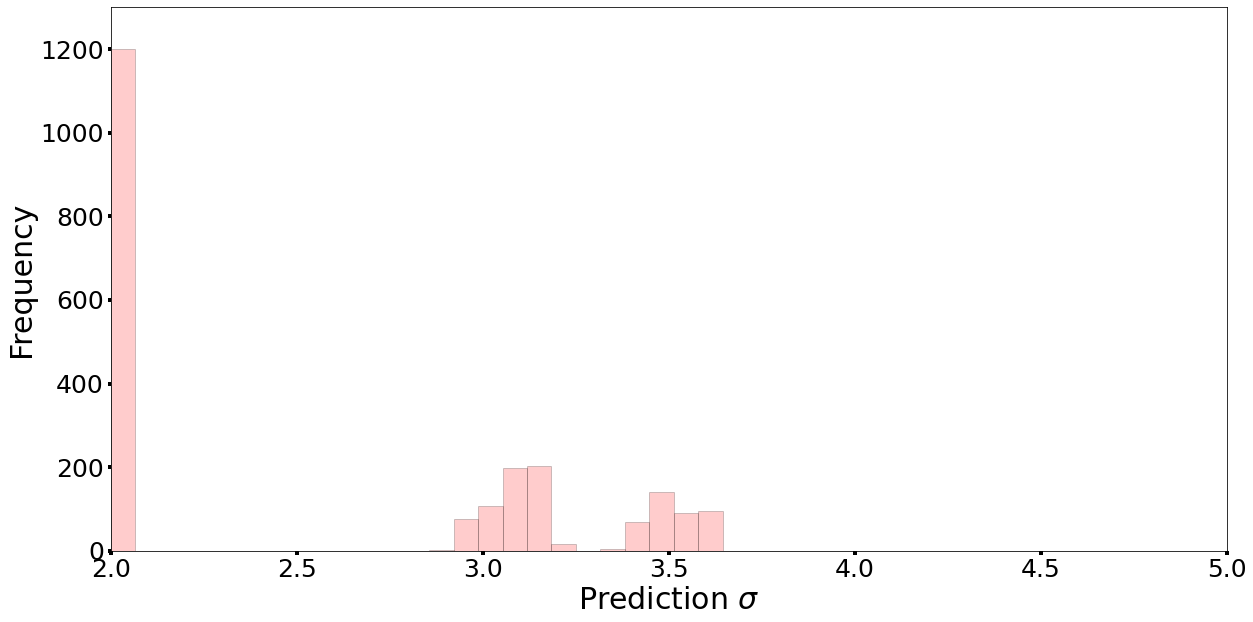

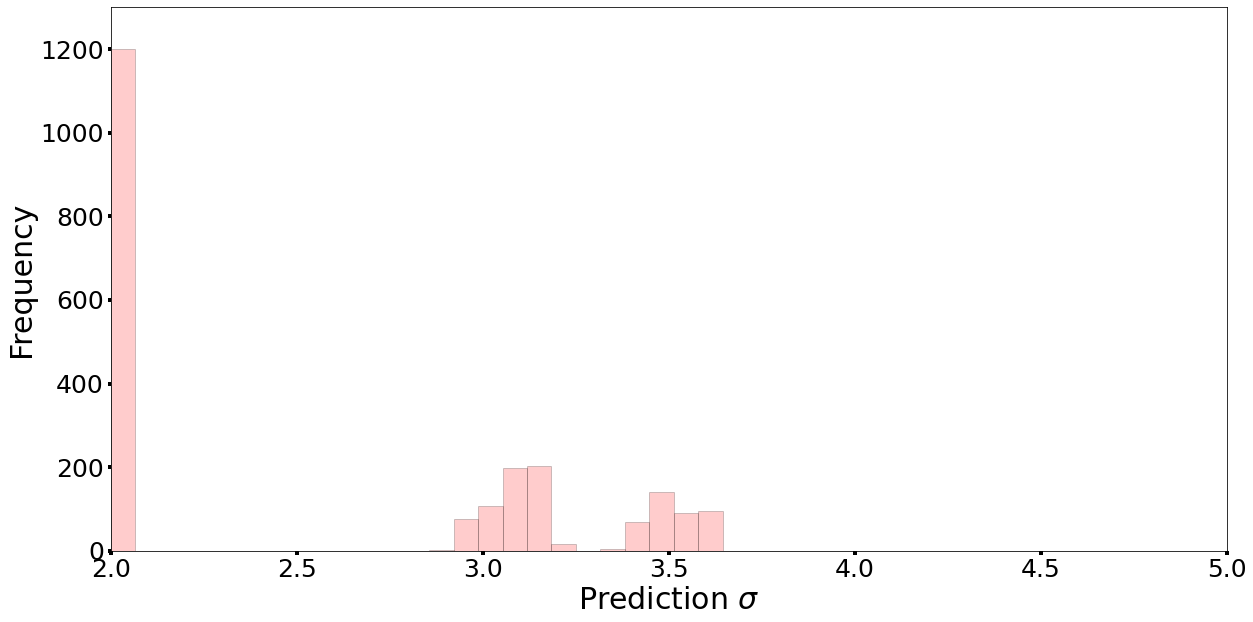

In [201]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))

n, bins, patches = plt.hist(test_pred_sigmas.flatten(), bins=25, 
         facecolor='red', linewidth=1, edgecolor='black', alpha=0.2)

axs.set_ylabel('Frequency', fontsize = 30)
axs.set_xlabel('Prediction ' + r'$\sigma$' , fontsize = 30)
axs.set_ylim(0, 1300)
axs.set_xlim(2, 5)

axs.tick_params(axis='both', which='major', labelsize=25, width=4)

plt.savefig('sigma_prediction_distribution.png')
plt.show()

In [148]:
random_sigma_true = np.random.uniform(low=2, high=5, 
                        size=TEST_DATASET_SIZE * (NB_NORMALS_X + NB_NORMALS_Y + NB_NORMALS_Z))
random_sigma_pred = np.random.uniform(low=2, high=5, 
                        size=TEST_DATASET_SIZE * (NB_NORMALS_X + NB_NORMALS_Y + NB_NORMALS_Z))
# random_sigma_pred = np.random.choice([2.0, (5.0 - 2.0)/ 2.0, 5.0],
#                                      TEST_DATASET_SIZE * (NB_NORMALS_X + NB_NORMALS_Y + NB_NORMALS_Z), (5-2)/ 2.0)

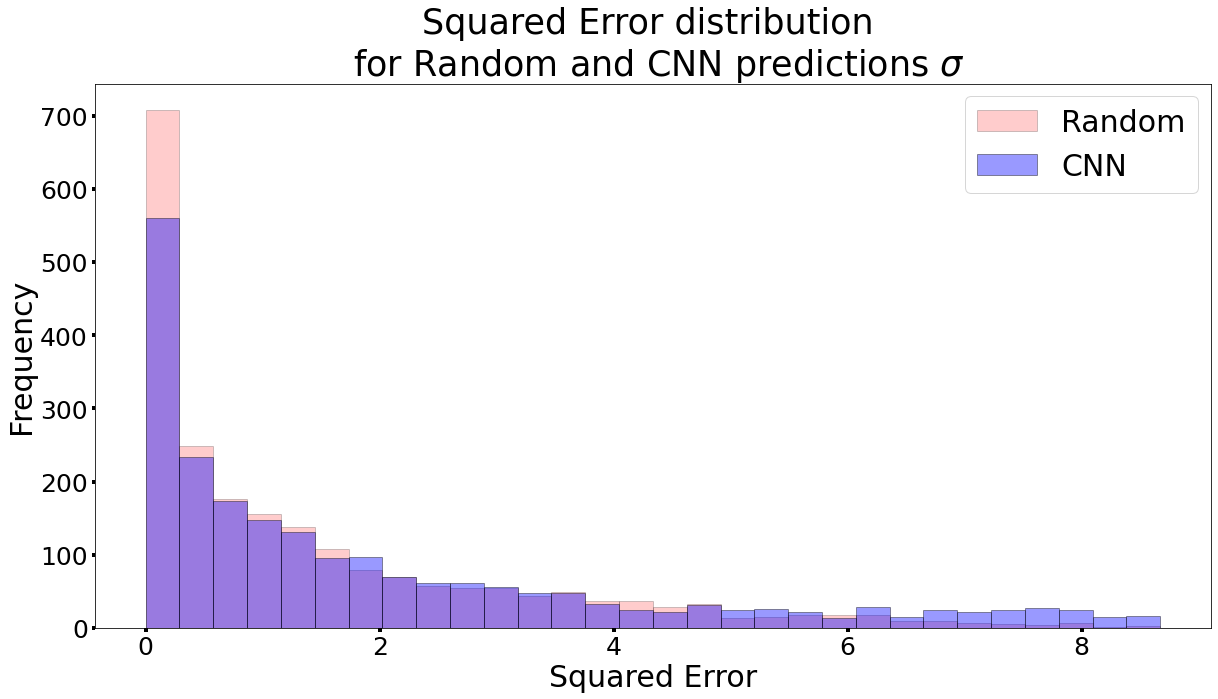

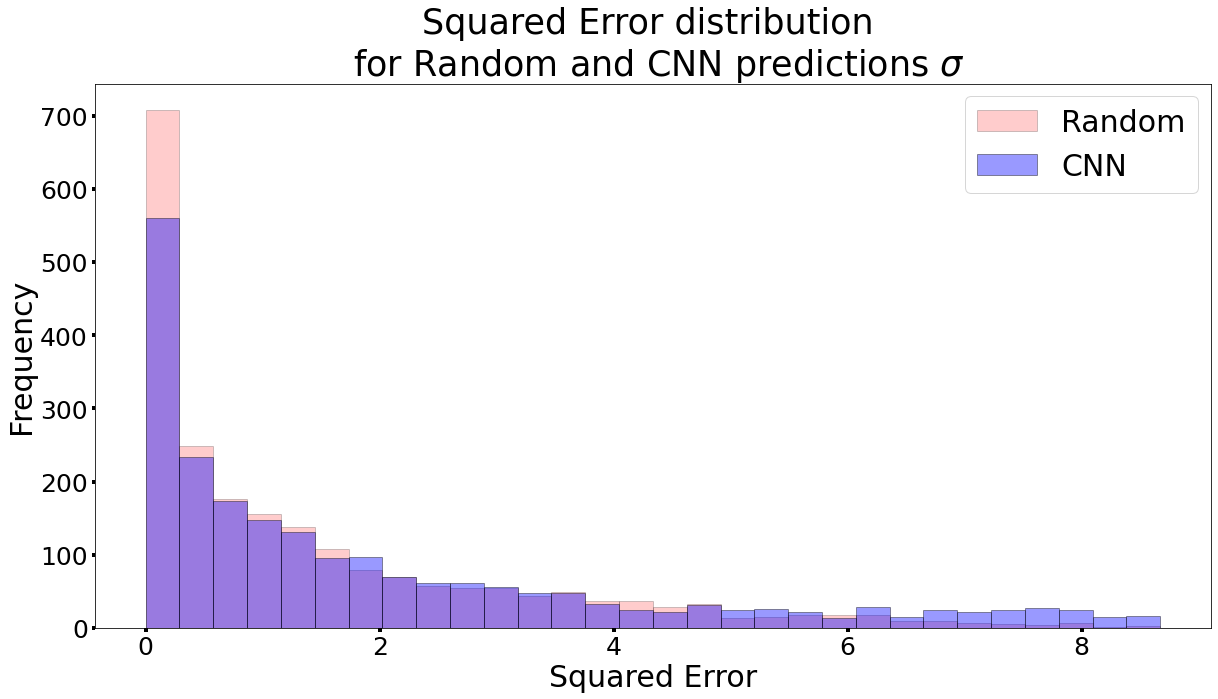

In [149]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))

random_distribution_sigma = (random_sigma_pred - random_sigma_true)**2
test_distribution_sigma = (test_pred_sigmas.flatten() - test_true_sigmas.flatten())**2

n, bins, patches = plt.hist(random_distribution_sigma, bins=30, 
         facecolor='red', linewidth=1, edgecolor='black', alpha=0.2, label='Random')
plt.hist(test_distribution_sigma, bins=bins, 
         facecolor='blue', linewidth=1, edgecolor='black', alpha=0.4, label='CNN')

axs.set_ylabel('Frequency', fontsize = 30)
axs.set_xlabel('Squared Error', fontsize = 30)
axs.set_title('Squared Error distribution \n for Random and CNN predictions $\sigma$', size=35)

axs.tick_params(axis='both', which='major', labelsize=25, width=4)

plt.legend(fontsize=30, loc=(0.78, 0.8))

plt.savefig('sigma_squared_error_distribution.png')
plt.show()

In [150]:
from scipy import stats

print(stats.kstest(random_distribution_sigma, test_distribution_sigma))
print(stats.kstest(random_distribution_sigma, test_distribution_sigma, alternative='less'))
print(stats.kstest(random_distribution_sigma, test_distribution_sigma, alternative='greater'))

KstestResult(statistic=0.09, pvalue=3.574261255096969e-08)
KstestResult(statistic=0.0018181818181818182, pvalue=0.9927552917050545)
KstestResult(statistic=0.09, pvalue=1.787130627548485e-08)
KstestResult(statistic=0.09, pvalue=3.574261255096969e-08)
KstestResult(statistic=0.0018181818181818182, pvalue=0.9927552917050545)
KstestResult(statistic=0.09, pvalue=1.787130627548485e-08)


### amplitude

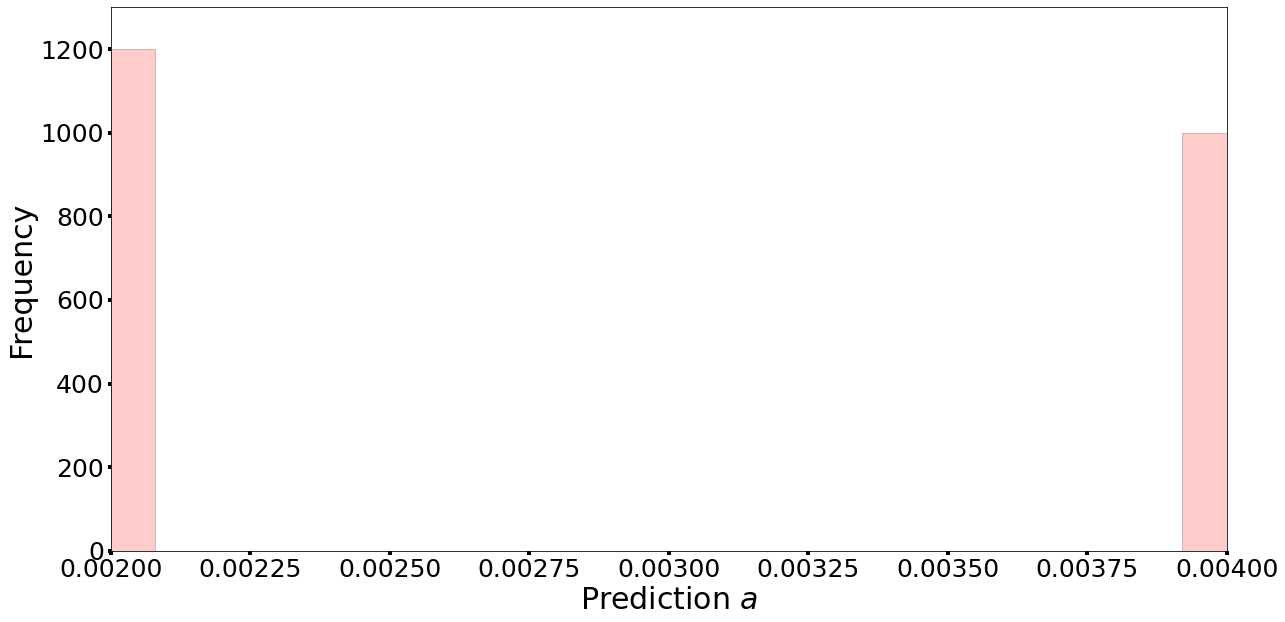

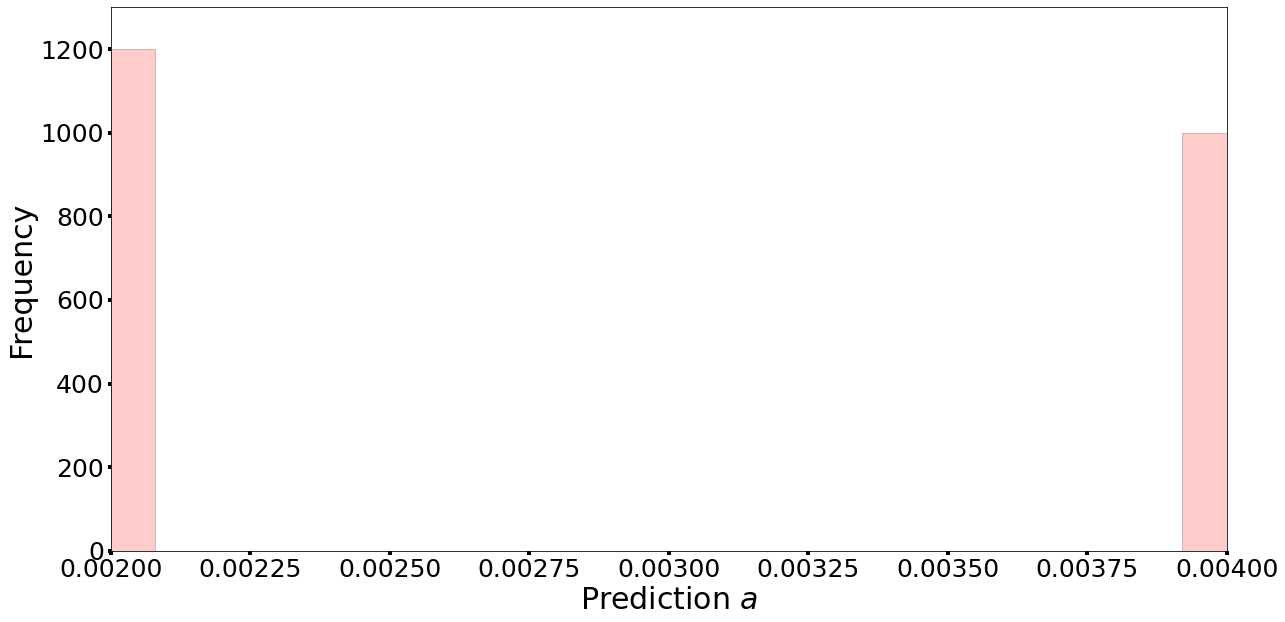

In [202]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))

n, bins, patches = plt.hist(test_pred_amplitudes.flatten(), bins=25, 
         facecolor='red', linewidth=1, edgecolor='black', alpha=0.2)

axs.set_ylabel('Frequency', fontsize = 30)
axs.set_xlabel('Prediction ' + r'$a$' , fontsize = 30)
axs.set_ylim(0, 1300)
axs.set_xlim(0.002, 0.004)

axs.tick_params(axis='both', which='major', labelsize=25, width=4)

plt.savefig('amplitude_prediction_distribution.png')
plt.show()

In [152]:
random_amplitude_true = np.random.uniform(low=0.002, high=0.004,
                        size=TEST_DATASET_SIZE * (NB_NORMALS_X + NB_NORMALS_Y + NB_NORMALS_Z))
random_amplitude_pred = np.random.uniform(low=0.002, high=0.004, 
                        size=TEST_DATASET_SIZE * (NB_NORMALS_X + NB_NORMALS_Y + NB_NORMALS_Z))
# random_amplitude_pred = np.full(TEST_DATASET_SIZE * (NB_NORMALS_X + NB_NORMALS_Y + NB_NORMALS_Z), (0.004-0.002)/2.0)

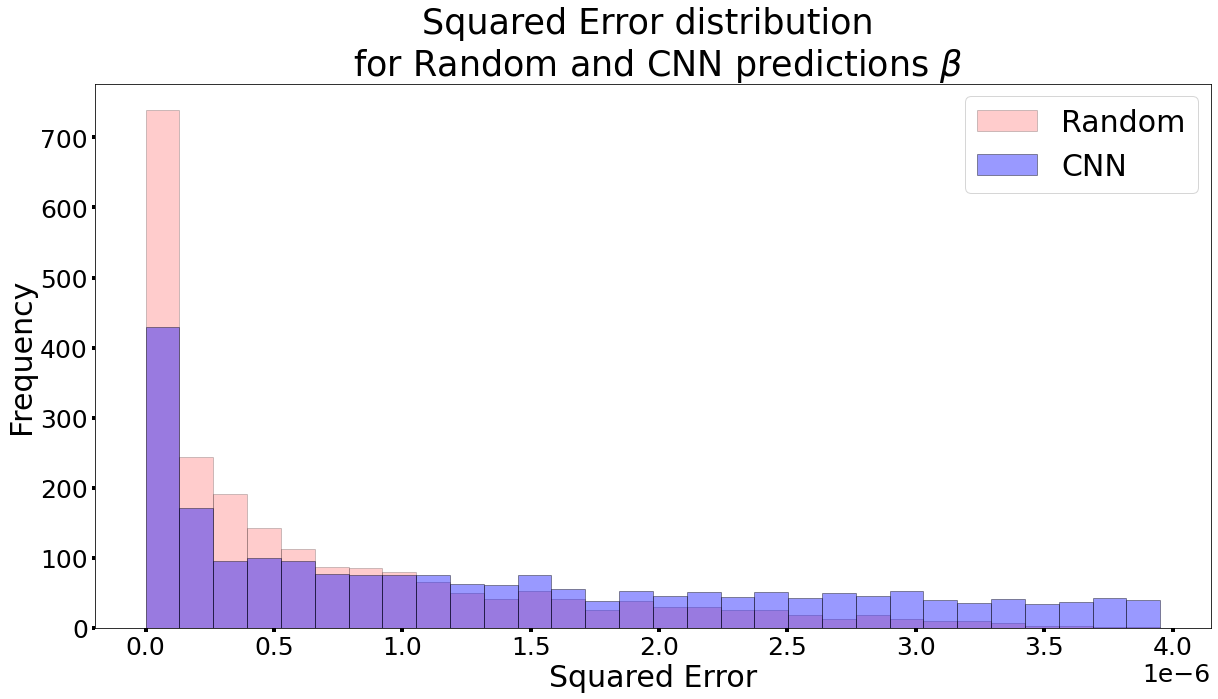

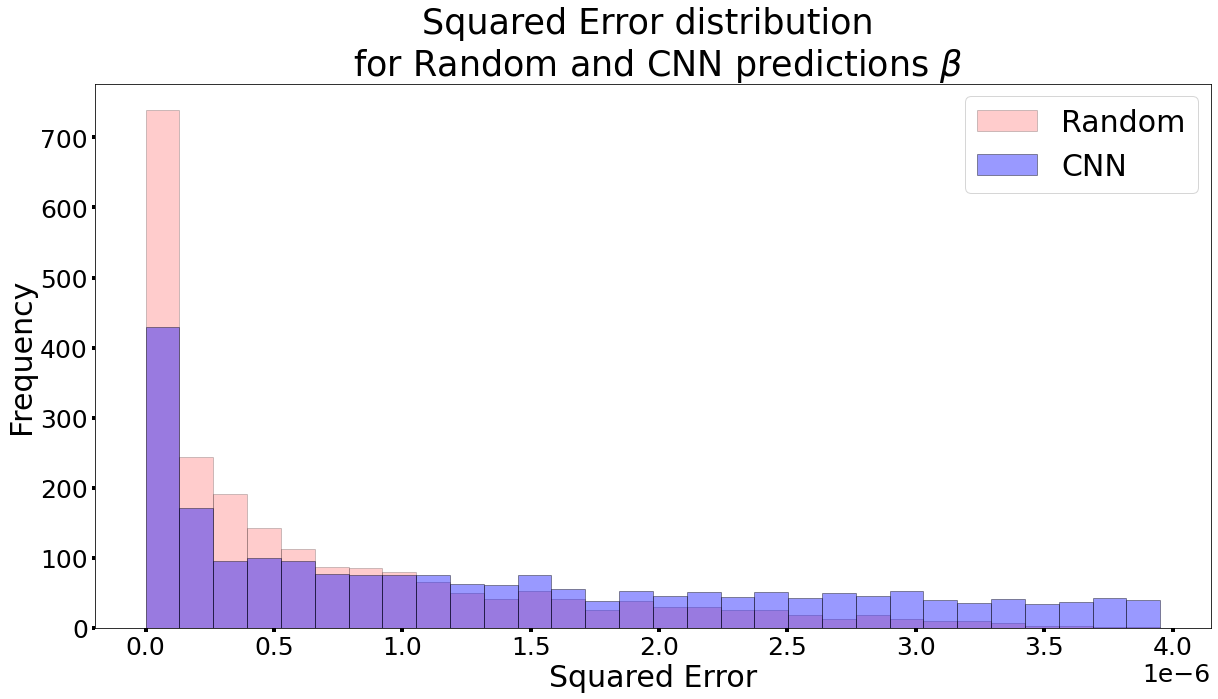

In [153]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))

random_distribution_amplitude = (random_amplitude_pred - random_amplitude_true)**2
test_distribution_amplitude = (test_pred_amplitudes.flatten() - test_true_amplitudes.flatten())**2

n, bins, patches = plt.hist(random_distribution_amplitude, bins=30, 
         facecolor='red', linewidth=1, edgecolor='black', alpha=0.2, label='Random')
plt.hist(test_distribution_amplitude, bins=bins,
         facecolor='blue', linewidth=1, edgecolor='black', alpha=0.4, label='CNN')

axs.set_ylabel('Frequency', fontsize = 30)
axs.set_xlabel('Squared Error', fontsize = 30)
axs.set_title('Squared Error distribution \n for Random and CNN predictions ' r'$\beta$', size=35)

axs.tick_params(axis='both', which='major', labelsize=25, width=4)
axs.xaxis.offsetText.set_fontsize(25)

plt.legend(fontsize=30, loc=(0.78, 0.8))

plt.savefig('amplitude_squared_error_distribution.png')
plt.show()

In [154]:
from scipy import stats

print(stats.kstest(random_distribution_amplitude, test_distribution_amplitude))
print(stats.kstest(random_distribution_amplitude, test_distribution_amplitude, alternative='less'))
print(stats.kstest(random_distribution_amplitude, test_distribution_amplitude, alternative='greater'))

KstestResult(statistic=0.26, pvalue=9.54631344523923e-66)
KstestResult(statistic=0.0, pvalue=1.0)
KstestResult(statistic=0.26, pvalue=4.773156722619612e-66)
KstestResult(statistic=0.26, pvalue=9.54631344523923e-66)
KstestResult(statistic=0.0, pvalue=1.0)
KstestResult(statistic=0.26, pvalue=4.773156722619612e-66)


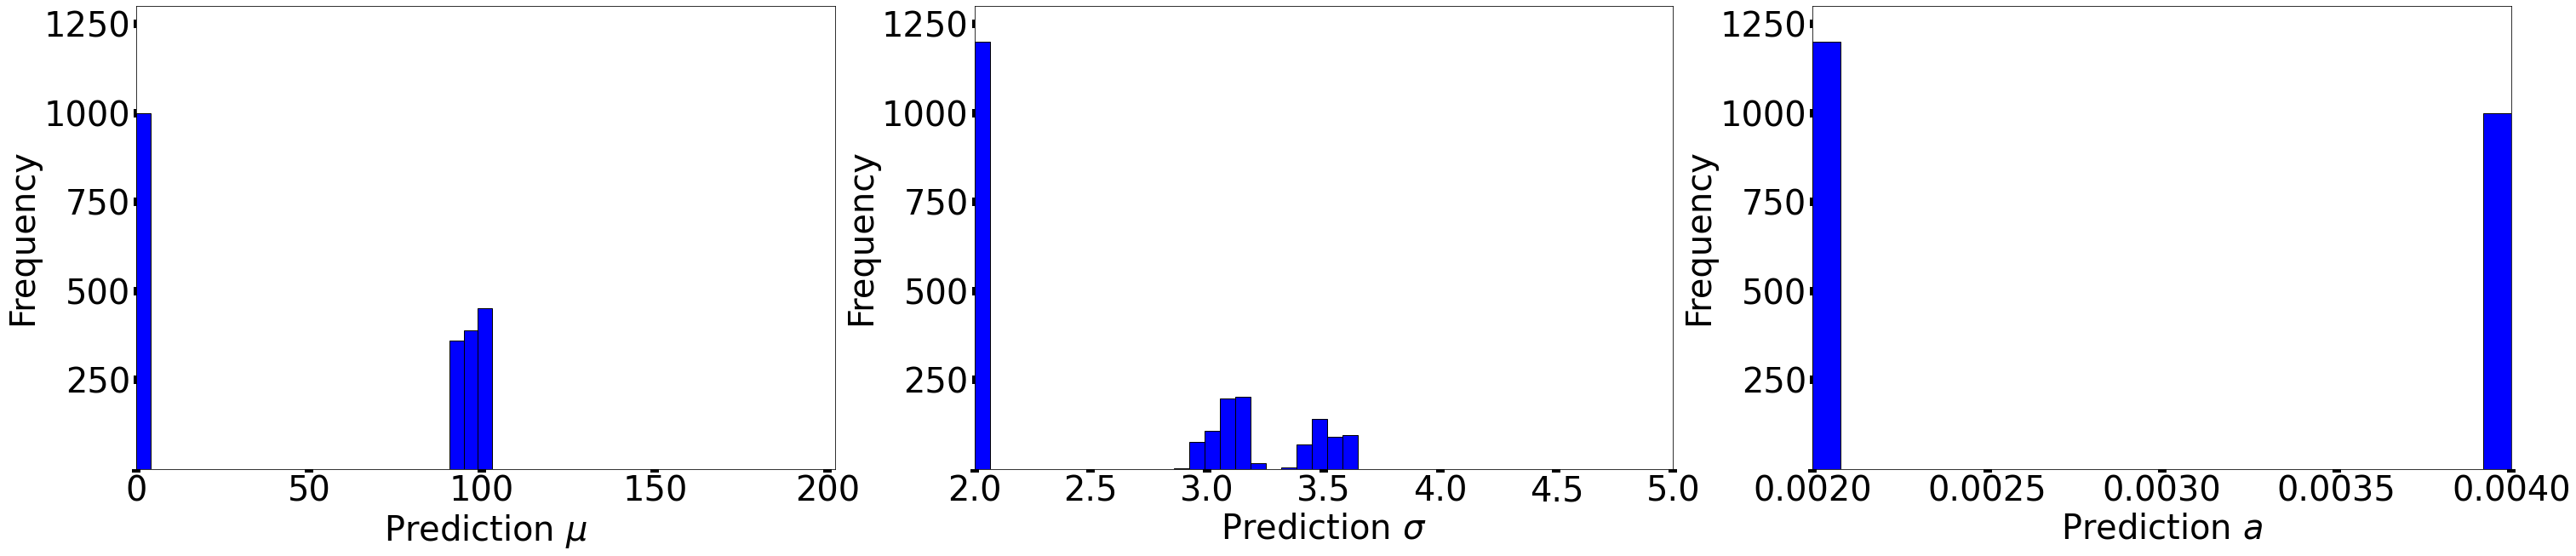

In [270]:
from matplotlib.ticker import FormatStrFormatter
fig, axs = plt.subplots(1, 3, figsize=(50, 10))

n, bins, patches = axs[0].hist(test_pred_mus.flatten(), bins=25, 
    facecolor='blue', linewidth=1, edgecolor='black', alpha=1)

axs[0].set_ylabel('Frequency', fontsize = 40)
axs[0].set_xlabel('Prediction ' + r'$\mu$' , fontsize = 40)
axs[0].set_ylim(0.001, 1300)
axs[0].set_xlim(0, NB_BINS)
axs[0].tick_params(axis='both', which='major', labelsize=40, width=10)

n, bins, patches = axs[1].hist(test_pred_sigmas.flatten(), bins=25, 
         facecolor='blue', linewidth=1, edgecolor='black', alpha=1)

axs[1].set_ylabel('Frequency', fontsize = 40)
axs[1].set_xlabel('Prediction ' + r'$\sigma$' , fontsize = 40)
axs[1].set_ylim(0.001, 1300)
axs[1].set_xlim(2, 5)
axs[1].tick_params(axis='both', which='major', labelsize=40, width=10)

n, bins, patches = axs[2].hist(test_pred_amplitudes.flatten(), bins=25, 
         facecolor='blue', linewidth=1, edgecolor='black', alpha=1)

axs[2].set_ylabel('Frequency', fontsize = 40)
axs[2].set_xlabel('Prediction ' + r'$a$' , fontsize = 40)
axs[2].set_ylim(0.001, 1300)
axs[2].set_xlim(0.002, 0.004)
axs[2].tick_params(axis='both', which='major', labelsize=40, width=10)
axs[2].xaxis.set_major_formatter(FormatStrFormatter('%.4f'))

plt.savefig('tcev3d_prediction_distribution.png')
plt.show()

# Trussart evaluation

## Hic matrices

In [155]:
trussart_hic_50 = np.loadtxt(TRUSSART_HIC_PATH_50, dtype='f', delimiter='\t')
scaler = MinMaxScaler()
trussart_hic_50 = scaler.fit_transform(trussart_hic_50)

In [156]:
trussart_hic_100 = np.loadtxt(TRUSSART_HIC_PATH_100, dtype='f', delimiter='\t')
scaler = MinMaxScaler()
trussart_hic_100 = scaler.fit_transform(trussart_hic_100)

In [157]:
trussart_hic_150 = np.loadtxt(TRUSSART_HIC_PATH_150, dtype='f', delimiter='\t')
scaler = MinMaxScaler()
trussart_hic_150 = scaler.fit_transform(trussart_hic_150)

In [158]:
trussart_hic_200 = np.loadtxt(TRUSSART_HIC_PATH_200, dtype='f', delimiter='\t')
scaler = MinMaxScaler()
trussart_hic_200 = scaler.fit_transform(trussart_hic_200)

## Structure matrices

In [159]:
trussart_structures = []

file_list = os.listdir(TRUSSART_STRUCTURES_PATH)
file_list = filter(lambda f: f.endswith('.xyz'), file_list)

for file_name in file_list:
    current_trussart_structure = np.loadtxt(TRUSSART_STRUCTURES_PATH + file_name, dtype='f', delimiter='\t')
    current_trussart_structure = current_trussart_structure[:,1:]
    current_trussart_structure = centralize_and_normalize_numpy(current_trussart_structure)
    trussart_structures.append(current_trussart_structure)
    
trussart_structures = np.asarray(trussart_structures)

## Construct dictionary of Trussart results

In [160]:
resolutions = [50, 100, 150, 200]
resolution_matrices = [trussart_hic_50, trussart_hic_100, trussart_hic_150, trussart_hic_200]

trussart_results = dict()

In [161]:
for i in range(4):
    
    current_resolution = resolutions[i]
    current_trussart_hic = resolution_matrices[i]
    
    # Add the gradient of the HiC to the input
    trussart_hic_matrix = np.zeros((3, NB_BINS, NB_BINS))
    trussart_hic_matrix[0] = current_trussart_hic
    trussart_hic_matrix[1] = np.gradient(current_trussart_hic)[0]
    trussart_hic_matrix[2] = np.gradient(current_trussart_hic)[1]
    
    # Format input
    trussart_hic_matrix_torch = torch.unsqueeze(torch.FloatTensor(trussart_hic_matrix), dim=0)
    trussart_hic_matrix_torch = torch.repeat_interleave(trussart_hic_matrix_torch, BATCH_SIZE, dim=0)

    # Feed to model
    mu, sigma, amplitude = model(trussart_hic_matrix_torch)
    
    # Extract results
    mu = mu[0].detach().numpy()
    sigma = sigma[0].detach().numpy()
    amplitude = amplitude[0].detach().numpy()
    
    mu_x = mu[:NB_NORMALS_X]
    mu_y = mu[NB_NORMALS_X:NB_NORMALS_X + NB_NORMALS_Y]
    mu_z = mu[NB_NORMALS_X + NB_NORMALS_Y:]
    
    sigma_x = sigma[:NB_NORMALS_X]
    sigma_y = sigma[NB_NORMALS_X:NB_NORMALS_X + NB_NORMALS_Y]
    sigma_z = sigma[NB_NORMALS_X + NB_NORMALS_Y:]
    
    amplitude_x = amplitude[:NB_NORMALS_X]
    amplitude_y = amplitude[NB_NORMALS_X:NB_NORMALS_X + NB_NORMALS_Y]
    amplitude_z = amplitude[NB_NORMALS_X + NB_NORMALS_Y:]
    
    predicted_signal_x = np.zeros(NB_BINS)
    for i in range(NB_NORMALS_X):
        predicted_signal_x += normal(np.arange(NB_BINS), mu_x[i], sigma_x[i], amplitude_x[i])
        
    predicted_signal_y = np.zeros(NB_BINS)
    for i in range(NB_NORMALS_Y):
        predicted_signal_y += normal(np.arange(NB_BINS), mu_y[i], sigma_y[i], amplitude_y[i])
        
    predicted_signal_z = np.zeros(NB_BINS)
    for i in range(NB_NORMALS_Z):
        predicted_signal_z += normal(np.arange(NB_BINS), mu_z[i], sigma_z[i], amplitude_z[i])
        
    predicted_signal = np.zeros((NB_BINS, EMBEDDING_SIZE))
    predicted_signal[:,0] = predicted_signal_x
    predicted_signal[:,1] = predicted_signal_y
    predicted_signal[:,2] = predicted_signal_z
    
    # Add results to dictionary of results
    trussart_results[current_resolution] = predicted_signal

## Visualization

In [162]:
per_axis_variance = np.var(trussart_structures, axis=0)

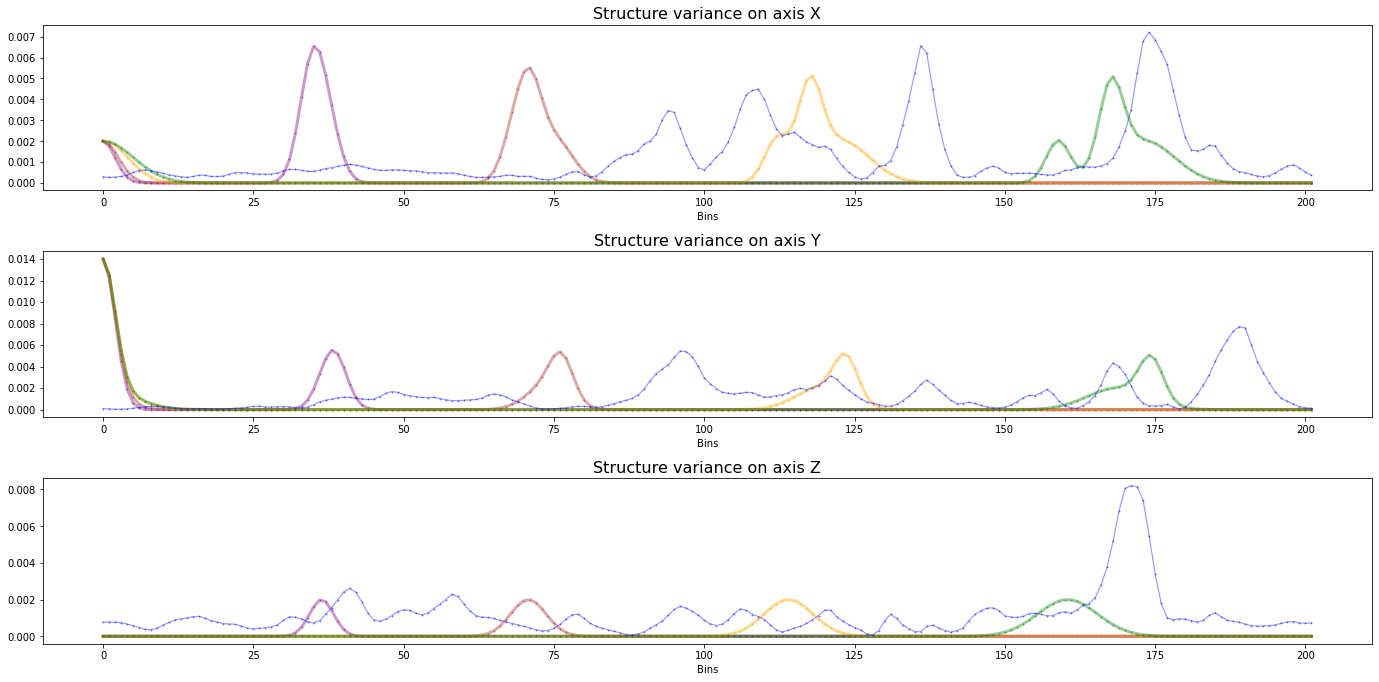

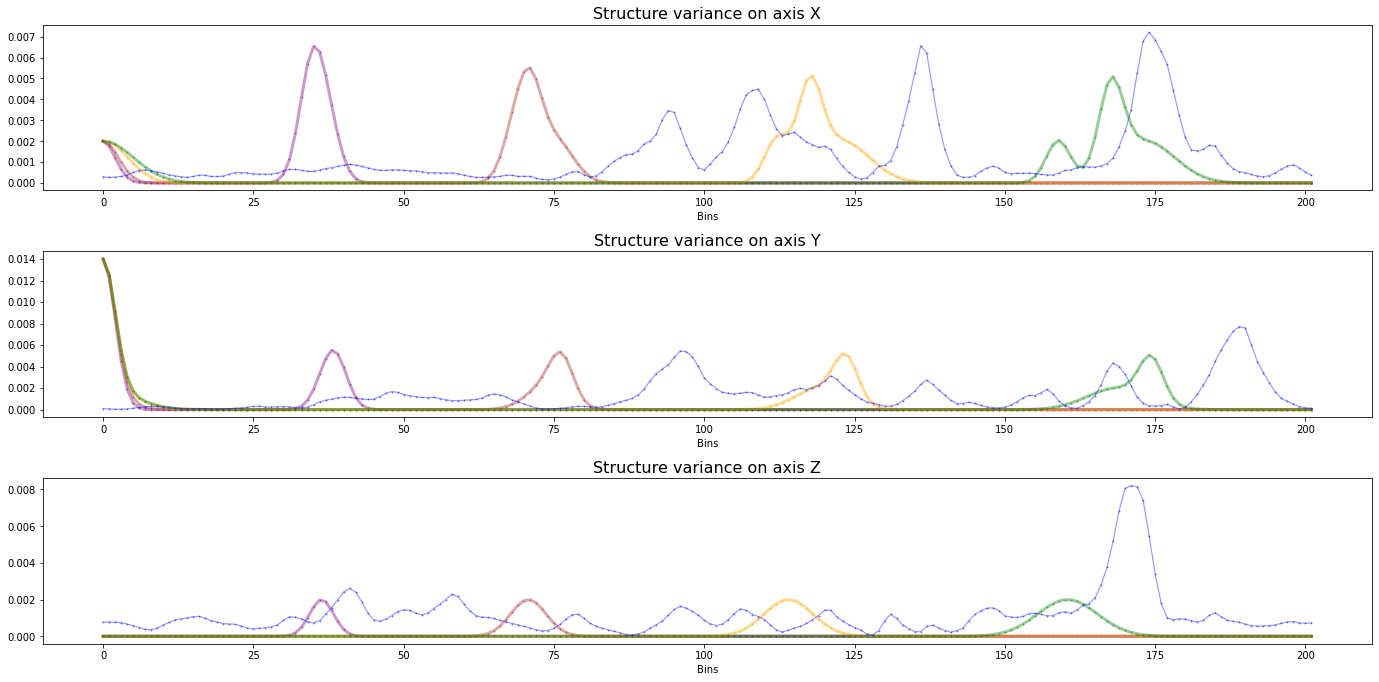

In [163]:
fig, axes = plt.subplots(3, 1, figsize=(20,10))
fig.tight_layout(pad=4.0)
axis_names = ['X','Y','Z']
per_resolution_color = ['purple', 'brown', 'orange', 'green']

# Plot prediction
for i in range(4):
    current_resolution = resolutions[i]
    current_color = per_resolution_color[i]
    current_predicted_signal = trussart_results[current_resolution]
    
    for j in range(EMBEDDING_SIZE):
        axes[j].plot(range(NB_BINS), current_predicted_signal[:, j], color=current_color, 
                  marker='o', linestyle='solid', linewidth=3, markersize=1, alpha=0.4)
        
# Plot original Trussart
for i in range(EMBEDDING_SIZE):

    # Trussart
    axes[i].plot(range(NB_BINS), per_axis_variance[:,i], color='blue', 
                  marker='o', linestyle='solid', linewidth=1.2, markersize=1, alpha=0.4)
    
    axes[i].set_title('Structure variance on axis ' + axis_names[i], fontsize=16)
    axes[i].set_xlabel('Bins', fontsize=10)

plt.show()

# Final plot

# Gaussian Fit

In [164]:
def gaus(x,a,x0,sigma):
    return np.asarray(a* np.exp(-(x-x0)**2/(2*sigma**2)))

In [165]:
def gaussian_fit(x, y):

    n = len(x)                          #the number of data
    mean = sum(x*y)/n                   #note this correction
    sigma = sum(y*(x-mean)**2)/n        #note this correction

    popt,pcov = curve_fit(gaus,x,y, maxfev=100000)

    plt.plot(x,y,'b+:',label='data')
    plt.plot(x,gaus(x,*popt),'ro:',label='fit')
    plt.legend()
    plt.show()

    return popt

## Trussart X axis

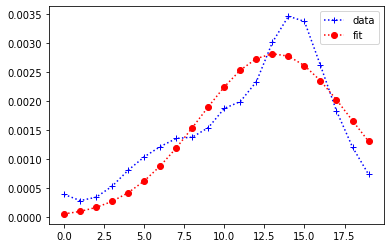

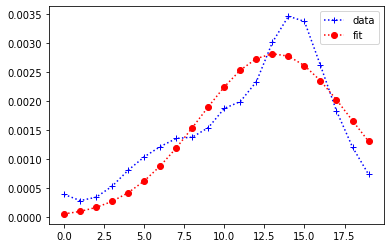

array([ 2.81651931e-03,  9.31674959e+01, -4.70503414e+00])

array([ 2.81651931e-03,  9.31674959e+01, -4.70503414e+00])

In [166]:
x = np.asarray(range(20))
y = per_axis_variance[80:100,0]

gaussian_1_params = gaussian_fit(x, y)
gaussian_1_params[1] += 80
gaussian_1_params

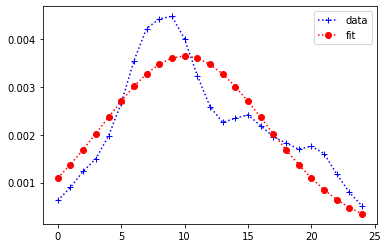

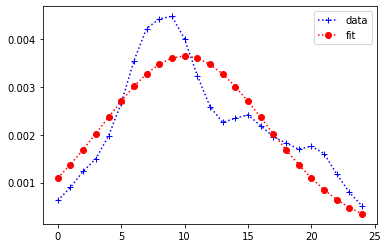

array([3.64695415e-03, 1.09992897e+02, 6.44205303e+00])

array([3.64695415e-03, 1.09992897e+02, 6.44205303e+00])

In [167]:
x = np.asarray(range(25))
y = per_axis_variance[100:125,0]

gaussian_2_params = gaussian_fit(x, y)
gaussian_2_params[1] += 100
gaussian_2_params

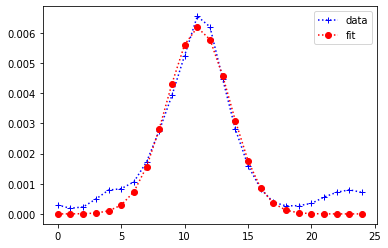

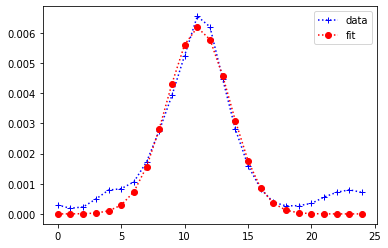

array([6.19132978e-03, 1.36092707e+02, 2.46607926e+00])

array([6.19132978e-03, 1.36092707e+02, 2.46607926e+00])

In [168]:
x = np.asarray(range(25))
y = per_axis_variance[125:150,0]

gaussian_3_params = gaussian_fit(x, y)
gaussian_3_params[1] += 125
gaussian_3_params

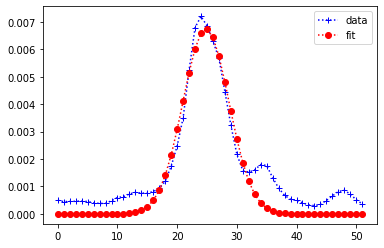

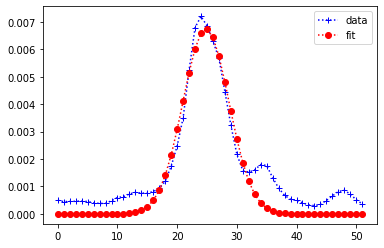

array([6.73906199e-03, 1.74826794e+02, 3.85512780e+00])

array([6.73906199e-03, 1.74826794e+02, 3.85512780e+00])

In [169]:
x = np.asarray(range(52))
y = per_axis_variance[150:,0]

gaussian_4_params = gaussian_fit(x, y)
gaussian_4_params[1] += 150
gaussian_4_params

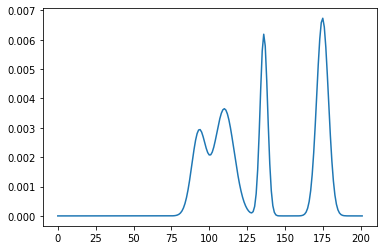

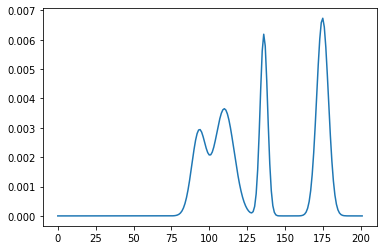

In [170]:
x = np.asarray(range(NB_BINS))

gauss_1 = gaus(x, gaussian_1_params[0], gaussian_1_params[1], gaussian_1_params[2])
gauss_2 = gaus(x, gaussian_2_params[0], gaussian_2_params[1], gaussian_2_params[2])
gauss_3 = gaus(x, gaussian_3_params[0], gaussian_3_params[1], gaussian_3_params[2])
gauss_4 = gaus(x, gaussian_4_params[0], gaussian_4_params[1], gaussian_4_params[2])

variance_modeling_axis_x = gauss_1 + gauss_2 + gauss_3 + gauss_4

plt.plot(x, variance_modeling_axis_x)

plt.show()

## Trussart Y axis

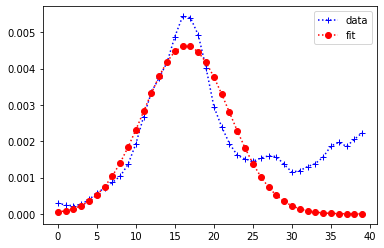

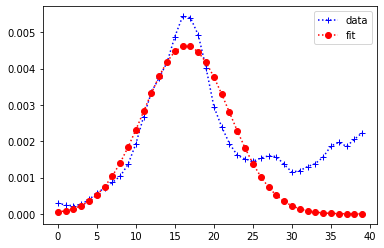

array([4.63306411e-03, 9.64725986e+01, 5.49112057e+00])

array([4.63306411e-03, 9.64725986e+01, 5.49112057e+00])

In [171]:
x = np.asarray(range(40))
y = per_axis_variance[80:120,1]

gaussian_1_params = gaussian_fit(x, y)
gaussian_1_params[1] += 80
gaussian_1_params

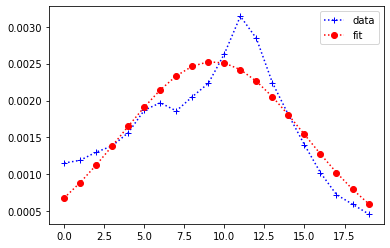

array([2.52782759e-03, 1.19291159e+02, 5.73484487e+00])

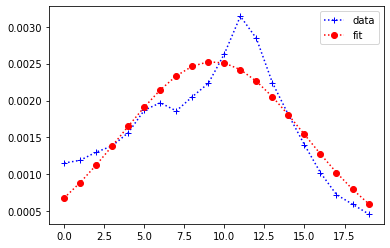

array([2.52782759e-03, 1.19291159e+02, 5.73484487e+00])

In [172]:
x = np.asarray(range(20))
y = per_axis_variance[110:130,1]

gaussian_2_params = gaussian_fit(x, y)
gaussian_2_params[1] += 110
gaussian_2_params

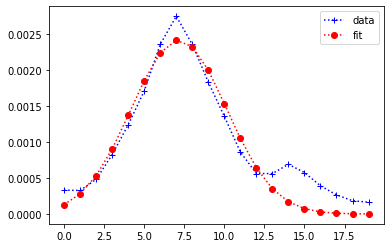

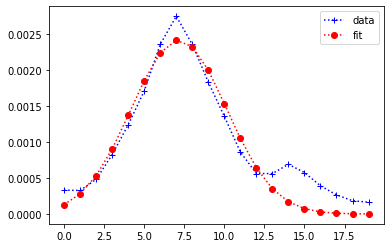

array([2.41472743e-03, 1.37163429e+02, 2.96816307e+00])

array([2.41472743e-03, 1.37163429e+02, 2.96816307e+00])

In [173]:
x = np.asarray(range(20))
y = per_axis_variance[130:150,1]

gaussian_3_params = gaussian_fit(x, y)
gaussian_3_params[1] += 130
gaussian_3_params

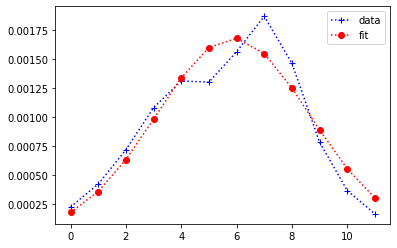

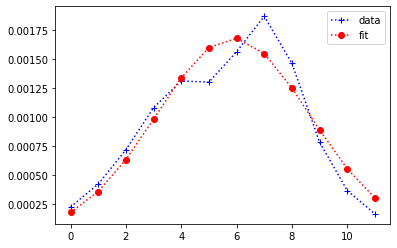

array([1.68122566e-03, 1.55872363e+02, 2.77125228e+00])

array([1.68122566e-03, 1.55872363e+02, 2.77125228e+00])

In [174]:
x = np.asarray(range(12))
y = per_axis_variance[150:162,1]

gaussian_4_params = gaussian_fit(x, y)
gaussian_4_params[1] += 150
gaussian_4_params

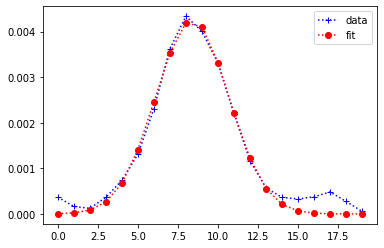

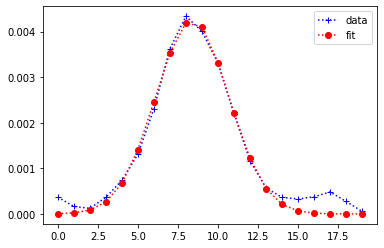

array([4.25187876e-03, 1.68393902e+02, 2.28387346e+00])

array([4.25187876e-03, 1.68393902e+02, 2.28387346e+00])

In [175]:
x = np.asarray(range(20))
y = per_axis_variance[160:180,1]

gaussian_5_params = gaussian_fit(x, y)
gaussian_5_params[1] += 160
gaussian_5_params

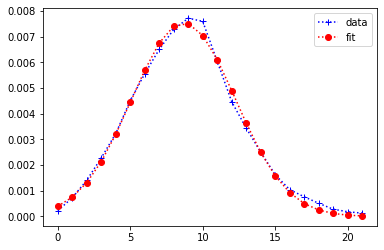

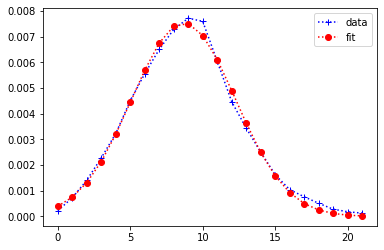

array([7.53788597e-03, 1.88680037e+02, 3.57517827e+00])

array([7.53788597e-03, 1.88680037e+02, 3.57517827e+00])

In [176]:
x = np.asarray(range(22))
y = per_axis_variance[180:,1]

gaussian_6_params = gaussian_fit(x, y)
gaussian_6_params[1] += 180
gaussian_6_params

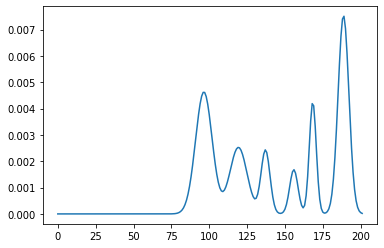

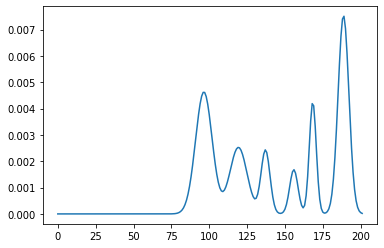

In [177]:
x = np.asarray(range(NB_BINS))

gauss_1 = gaus(x, gaussian_1_params[0], gaussian_1_params[1], gaussian_1_params[2])
gauss_2 = gaus(x, gaussian_2_params[0], gaussian_2_params[1], gaussian_2_params[2])
gauss_3 = gaus(x, gaussian_3_params[0], gaussian_3_params[1], gaussian_3_params[2])
gauss_4 = gaus(x, gaussian_4_params[0], gaussian_4_params[1], gaussian_4_params[2])
gauss_5 = gaus(x, gaussian_5_params[0], gaussian_5_params[1], gaussian_5_params[2])
gauss_6 = gaus(x, gaussian_6_params[0], gaussian_6_params[1], gaussian_6_params[2])

variance_modeling_axis_y = gauss_1 + gauss_2 + gauss_3 + gauss_4 + gauss_5 + gauss_6

plt.plot(x, variance_modeling_axis_y)

plt.show()

## Trussart Z axis

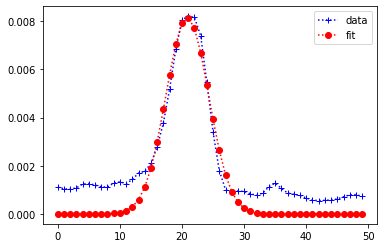

array([8.15516583e-03, 1.70851094e+02, 3.42844501e+00])

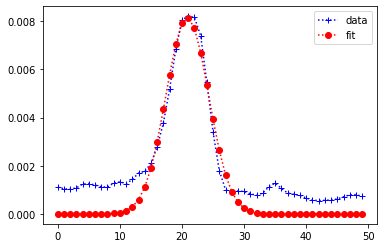

array([8.15516583e-03, 1.70851094e+02, 3.42844501e+00])

In [178]:
x = np.asarray(range(50))
y = per_axis_variance[150:200,2]

gaussian_1_params = gaussian_fit(x, y)
gaussian_1_params[1] += 150
gaussian_1_params

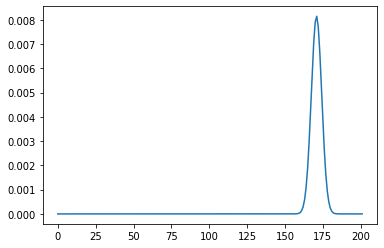

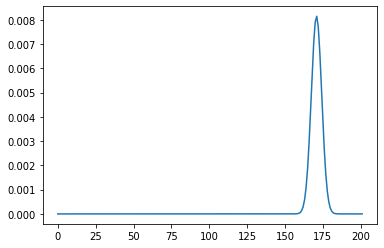

In [179]:
x = np.asarray(range(NB_BINS))

gauss_1 = gaus(x, gaussian_1_params[0], gaussian_1_params[1], gaussian_1_params[2])

variance_modeling_axis_z = gauss_1

plt.plot(x, variance_modeling_axis_z)

plt.show()

# Final variance modeling

In [180]:
variance_modeling = \
    np.vstack((np.vstack((variance_modeling_axis_x, variance_modeling_axis_y)), variance_modeling_axis_z))

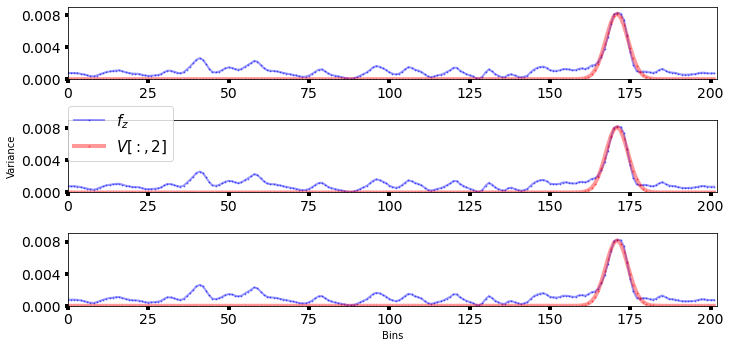

In [248]:
fig, axs = plt.subplots(3, 1, figsize=(10, 5))
fig.tight_layout(pad=2.0)
axis_names = ['X','Y','Z']

############################################################

# Trussart
axs[0].plot(range(NB_BINS), per_axis_variance[:,i], color='blue', 
              marker='o', linestyle='solid', linewidth=2, markersize=1, alpha=0.4, label=r'$f_x$')
axs[0].plot(range(NB_BINS), variance_modeling[i,:], color='red', 
              marker='o', linestyle='solid', linewidth=4, markersize=1, alpha=0.4, label=r'$V[:,0]$')

#     axs[i].set_title('Structure variance on axis ' + axis_names[i], fontsize=16)
axs[0].set_xlim(0, NB_BINS)

axs[0].set_ylim(0, 0.009)
l = np.asarray(range(0, 10, 4)) / 1000
axs[0].set_yticks(ticks=l)
axs[0].tick_params(axis='both', which='major', labelsize=14, width=4)

############################################################

# Trussart
axs[1].plot(range(NB_BINS), per_axis_variance[:,i], color='blue', 
              marker='o', linestyle='solid', linewidth=2, markersize=1, alpha=0.4, label=r'$f_y$')
axs[1].plot(range(NB_BINS), variance_modeling[i,:], color='red', 
              marker='o', linestyle='solid', linewidth=4, markersize=1, alpha=0.4, label=r'$V[:,1]$')

#     axs[i].set_title('Structure variance on axis ' + axis_names[i], fontsize=16)
axs[1].set_xlim(0, NB_BINS)

axs[1].set_ylim(0, 0.009)
l = np.asarray(range(0, 10, 4)) / 1000
axs[1].set_yticks(ticks=l)
axs[1].tick_params(axis='both', which='major', labelsize=14, width=4)

axs[1].set_ylabel('Variance', fontsize=10)

############################################################

# Trussart
axs[2].plot(range(NB_BINS), per_axis_variance[:,i], color='blue', 
              marker='o', linestyle='solid', linewidth=2, markersize=1, alpha=0.4, label=r'$f_z$')
axs[2].plot(range(NB_BINS), variance_modeling[i,:], color='red', 
              marker='o', linestyle='solid', linewidth=4, markersize=1, alpha=0.4, label=r'$V[:,2]$')

#     axs[i].set_title('Structure variance on axis ' + axis_names[i], fontsize=16)
axs[2].set_xlim(0, NB_BINS)

axs[2].set_ylim(0, 0.009)
l = np.asarray(range(0, 10, 4)) / 1000
axs[2].set_yticks(ticks=l)
axs[2].tick_params(axis='both', which='major', labelsize=14, width=4)

axs[2].set_xlabel('Bins', fontsize=10)

plt.legend(fontsize=15, loc=(0, 2))

# plt.savefig('modeled_sample_per_axis_structure_variance.png')

plt.show()

# Final prediction to variance modeling

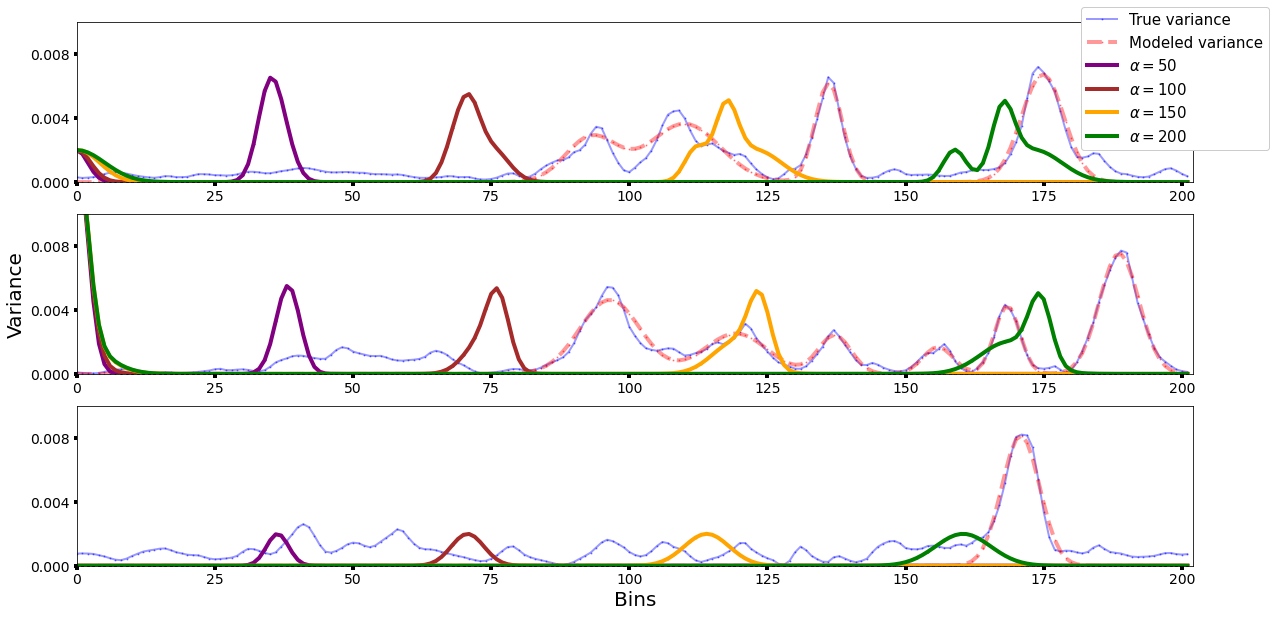

In [282]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10))
# fig.tight_layout(pad=7.0)
axis_names = ['X','Y','Z']
per_resolution_label = [r'$\alpha = 50$', r'$\alpha = 100$', r'$\alpha = 150$', r'$\alpha = 200$']

# Plot Trussart
for i in range(EMBEDDING_SIZE):
    
    # Trussart
    axs[i].plot(range(NB_BINS), per_axis_variance[:,i], color='blue', 
                  marker='o', linestyle='solid', linewidth=2, markersize=1, alpha=0.4, label='True variance')
    axs[i].plot(range(NB_BINS), variance_modeling[i,:], color='red', 
                  marker='o', linestyle='dashed', linewidth=4, markersize=1, alpha=0.4, label='Modeled variance')
    
    
#     axs[i].set_title('Structure variance on axis ' + axis_names[i], fontsize=16)
    axs[i].set_xlim(0, NB_BINS)
    
    axs[i].set_ylim(0, 0.01)
    l = np.asarray(range(0, 10, 4)) / 1000
    axs[i].set_yticks(ticks=l)
    
    axs[i].tick_params(axis='both', which='major', labelsize=14, width=4)
    
    if i == 2:
        axs[i].set_xlabel('Bins', fontsize=20)
    if i == 1:
        axs[i].set_ylabel('Variance', fontsize=20)
        
# Plot prediction
for i in range(4):
    current_resolution = resolutions[i]
    current_color = per_resolution_color[i]
    current_label = per_resolution_label[i]
    current_predicted_signal = trussart_results[current_resolution]
    
    for j in range(EMBEDDING_SIZE):
        axs[j].plot(range(NB_BINS), current_predicted_signal[:, j], color=current_color, 
                  marker='o', linestyle='solid', label=current_label, linewidth=4, markersize=1, alpha=1)
        

plt.legend(fontsize=15, loc=(0.9, 2.6), framealpha=1)

plt.savefig('predicted_sample_per_axis_structure_variance.png')

plt.show()